<a href="https://colab.research.google.com/github/JeromeHoen/OC_P5-Segmentez_les_comportements_de_clients/blob/master/Notebook_P5_Segmentez_les_comportements_de_clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentez les comportements de clients

##Import des fonctions et du DataFrame

In [1]:
# data management
import pandas as pd    
import numpy as np
import scipy
import pickle

# data viz
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

!pip install cufflinks
import cufflinks as cf
cf.go_offline()

# google colab modules

from google.colab import files

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
    
# ML algortihms

# data preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# scoring and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

# dimension reduction
from sklearn.decomposition import PCA

# classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# regression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier

# dimension reduction 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS
from umap import UMAP

# bayesian optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

# performance
from functools import wraps
import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        t_start = time.time()
        result = f(*args, **kwargs)
        t_end = time.time()
        print(f"function {f.__name__} with args {args}, kwargs {kwargs} took {t_end - t_start: 0.4f} sec.")
        return result
    return wrap
    
# deep learning
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import load_model
from sklearn.utils import resample

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=b8a0963f8b8ca314d9aa8caf3f8b1f494e5369654de9d1f3874df5c7ce495db4
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


Using TensorFlow backend.


In [0]:
# custom functions

from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.multiclass import unique_labels

def full_print(*arg, columns=20, rows=60, colwidth=50):
    """Set pandas.option_context and display a DataFrame"""
    with pd.option_context('display.max_columns', columns,
                           'display.max_rows', rows,
                           'display.max_colwidth', colwidth):
        display(*arg)

class print_color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
        
def display_circles(pca, axis_ranks=[(0, 1)], labels=None, label_rotation=0, lims=None):
    pcs = pca.components_
    n_comp = pca.n_components_
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(X, **kwargs):
    """
    Authors: Mathew Kallada
    License: BSD 3 clause
    =========================================
    Plot Hierarachical Clustering Dendrogram 
    =========================================
    This example plots the corresponding dendrogram of a hierarchical clustering
    using AgglomerativeClustering and the dendrogram method available in scipy.
    """

    plt.figure(figsize=(10, 50))
    plt.title('Hierarchical Clustering Dendrogram')

    model = AgglomerativeClustering()
    model = model.fit(X)

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='left', **kwargs)
    
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          **kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if not 'cmap' in kwargs:
        kwargs['cmap'] = plt.cm.Reds
    if not 'vmin' in kwargs and normalize:
        kwargs['vmin'] = 0
    if not 'vmax' in kwargs and normalize:
        kwargs['vmax'] = 1

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    if classes is None:
        classes = unique_labels(y_true, y_pred)
    else:
        classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', **kwargs)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.grid(False)
    fig.tight_layout()
    return ax

def plot_barh(data, title=None, fig_width=None, color='red', fmt='.0f'):
    """Horizontal barplot for a Series
    """

    if not fig_width:
        fig_width = 12
    
    figsize = (fig_width, 0.4 * data.shape[0])

    fig, ax = plt.subplots(figsize=figsize)
    data.plot.barh(ax=ax, color=color)
    plt.gca().invert_yaxis()

    if not title and hasattr(data, "name"):
        title = data.name

    if title:
        ax.set_title(title, fontweight='bold')    

    ax.xaxis.tick_top()
    ax.yaxis.grid(False)

    width_in_pix = figsize[0] * fig.get_dpi()
    width_in_val = max(data.values)

    N_PIXELS_OFFSET = 2
    offset = N_PIXELS_OFFSET * width_in_val / width_in_pix

    for i, val in enumerate(data.values):
        ax.text(
            val + offset, i, format(val, fmt), 
            color=color, fontweight='bold', va='center'
        )

    return ax

def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

def filter_rows_csr(mat, indices):
    """
    Keep the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.zeros(mat.shape[0], dtype=bool)
    mask[indices] = True
    return mat[mask]
        

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2019-11-12 15:22:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx  100%[===================>]  22.62M  11.1MB/s    in 2.0s    

2019-11-12 15:22:57 (11.1 MB/s) - ‘Online Retail.xlsx’ saved [23715344/23715344]



In [4]:
dtypes = dict(
    InvoiceNo = 'str',
    StockCode = 'str',
    Description = 'str',
    Quantity = 'int64',
    InvoiceDate = 'datetime64',
    UnitPrice = 'float64',
    CustomerID = 'str',
    Country = 'category',
)

df = pd.read_excel("Online Retail.xlsx", dtype=dtypes)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
first_order = df.InvoiceDate.min()
last_order = df.InvoiceDate.max()

print(f"Début du jeu de données  : {first_order}")
print(f"Fin du jeu de données  : {last_order}")
print(f"Etendue de la période : {last_order - first_order}")

Début du jeu de données  : 2010-12-01 08:26:00
Fin du jeu de données  : 2011-12-09 12:50:00
Etendue de la période : 373 days 04:24:00


##Nettoyage des données

###Regroupement des codes en doublon

In [0]:
df['StockCode'] = df.StockCode.str.upper()

In [0]:
df['Description'] = df['Description'].fillna('')
df['Description'] = df.groupby('StockCode').Description.transform(lambda x: pd.Series.mode(x)[0])

### Regroupement des commandes lignes de commande d'un même article

In [8]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# group invoices' date to the last date seen
df['InvoiceDate'] = df.groupby('InvoiceNo').InvoiceDate.transform('max')

# remove hour minutes as not useful
df['InvoiceDate'] = df['InvoiceDate'].dt.date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# count number of orders per day for same customer
df['N_orders'] = df.groupby(['CustomerID', 'InvoiceDate']).InvoiceNo.transform('nunique')
df['N_orders'] = df['N_orders'].fillna(1)

# merge lines so that InvoiceNo / StockCode is a unique key
df['Quantity'] = df.groupby(['InvoiceNo', 'StockCode']).Quantity.transform('sum')
df['TotalPrice'] = df.groupby(['InvoiceNo', 'StockCode']).TotalPrice.transform('sum')
df.drop_duplicates(['InvoiceNo', 'StockCode'], inplace=True)

# recalculate the unit price based on new qty and total
df['UnitPrice'] = (df['TotalPrice'] / df['Quantity']).fillna(0)

df['TotalInvoice'] = df.groupby('InvoiceNo').TotalPrice.transform('sum')

df.sort_values(['CustomerID', 'InvoiceDate', 'InvoiceNo'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,N_orders,TotalInvoice
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346,United Kingdom,77183.6,2.0,77183.60
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18,1.04,12346,United Kingdom,-77183.6,2.0,-77183.60
2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07,2.10,12347,Iceland,25.2,1.0,711.79
3,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07,4.25,12347,Iceland,17.0,1.0,711.79
4,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07,3.25,12347,Iceland,39.0,1.0,711.79


###Séparation entre les lignes comptables et les lignes de vente

In [0]:
accounting_codes = ['AMAZONFEE', 'B', 'CRUK', 'BANK CHARGES']
accounting = df[df.StockCode.isin(accounting_codes)]
df = df[~df.StockCode.isin(accounting_codes)]

###Regroupement des commandes passées le même jour

Afin d'éviter les problèmes avec de nombreuses lignes passées et annulées le même jour qui parasitent la lecture des résultats.

In [10]:
next_line = df[['InvoiceNo', 'InvoiceDate', 'CustomerID']].shift(-1)

next_line.head()

,InvoiceNo,InvoiceDate,CustomerID
0,C541433,2011-01-18,12346
1,537626,2010-12-07,12347
2,537626,2010-12-07,12347
3,537626,2010-12-07,12347
4,537626,2010-12-07,12347


In [11]:
crit1 = df['InvoiceNo'] != next_line['InvoiceNo']
crit2 = df['CustomerID'] == next_line['CustomerID']
crit3 = ~df['CustomerID'].isna()
next_order = next_line[crit1 & crit2 & crit3]

next_order['InvoiceDate'] = next_order['InvoiceDate'].dt.date
next_order['DaysDiff'] = (next_order['InvoiceDate'] - df['InvoiceDate'].dt.date).dt.days
next_order['PreviousInvoiceNo'] = df['InvoiceNo']
next_order.head()

,InvoiceNo,InvoiceDate,CustomerID,DaysDiff,PreviousInvoiceNo
0,C541433,2011-01-18,12346,0.0,541431
32,542237,2011-01-26,12347,50.0,537626
61,549222,2011-04-07,12347,71.0,542237
85,556201,2011-06-09,12347,63.0,549222
103,562032,2011-08-02,12347,54.0,556201


In [0]:
crit = next_order['DaysDiff'] == 0
orders_to_merge = next_order[crit][['InvoiceNo', 'PreviousInvoiceNo']]
orders_to_merge = dict(orders_to_merge[['InvoiceNo', 'PreviousInvoiceNo']].values)

# flatten the dict, go straight to last order:
def get_deeper(key, d):
    if key in d:
        return get_deeper(d[key], d)
    else:
        return key

# fill mapping dict with all orders in the dataset
mapping_dict = {}
for order in df['InvoiceNo'].unique():
    if order in orders_to_merge:
        mapping_dict[order] = get_deeper(orders_to_merge[order], orders_to_merge)
    else:
        mapping_dict[order] = order

In [13]:
df['InvoiceNo'] = df['InvoiceNo'].map(mapping_dict)

# group invoices' date to the last date seen
df['InvoiceDate'] = df.groupby('InvoiceNo').InvoiceDate.transform('max')

# merge lines so that InvoiceNo / StockCode is a unique key
df['Quantity'] = df.groupby(['InvoiceNo', 'StockCode']).Quantity.transform('sum')
df['TotalPrice'] = df.groupby(['InvoiceNo', 'StockCode']).TotalPrice.transform('sum')
df.drop_duplicates(['InvoiceNo', 'StockCode'], inplace=True)

# recalculate the unit price based on new qty and total
df['UnitPrice'] = (df['TotalPrice'] / df['Quantity']).fillna(0)

df['TotalInvoice'] = df.groupby('InvoiceNo').TotalPrice.transform('sum')

# delete lines that cancelled each other
df = df[df.TotalPrice.abs() > 0.0001]

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,N_orders,TotalInvoice
2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07,2.10,12347,Iceland,25.2,1.0,711.79
3,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07,4.25,12347,Iceland,17.0,1.0,711.79
4,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07,3.25,12347,Iceland,39.0,1.0,711.79
5,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07,0.65,12347,Iceland,23.4,1.0,711.79
6,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07,1.25,12347,Iceland,15.0,1.0,711.79


###Correction manuelle de la commande 556442

In [14]:
df[df['InvoiceNo']=="556442"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,N_orders,TotalInvoice
196604,556442,22502,PICNIC BASKET WICKER SMALL,61,2011-06-10,649.5,15098,United Kingdom,39619.5,5.0,649.5
196607,556442,M,Manual,-1,2011-06-10,38970.0,15098,United Kingdom,-38970.0,5.0,649.5


In [15]:
df[df['InvoiceNo']=="556442"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,N_orders,TotalInvoice
196604,556442,22502,PICNIC BASKET WICKER SMALL,61,2011-06-10,649.5,15098,United Kingdom,39619.5,5.0,649.5
196607,556442,M,Manual,-1,2011-06-10,38970.0,15098,United Kingdom,-38970.0,5.0,649.5


In [0]:
european_countries = [
    'United Kingdom', 'France', 'Netherlands', 'Germany', 'Norway', 'EIRE', 
    'Switzerland', 'Spain', 'Poland', 'Portugal', 'Italy', 'Belgium', 'Malta',
    'Lithuania', 'Iceland', 'Channel Islands', 'Denmark', 'Cyprus', 'Sweden',
    'Finland', 'Austria', 'Greece', 'Czech Republic', 'European Community'
]

df['CountryGroup'] = 'NotEurope'
df.loc[(df.Country.isin(european_countries)), 'CountryGroup']  = 'Europe'
df.loc[(df.Country == "United Kingdom"), 'CountryGroup']  = 'UK'

##Analyse exploratoire

In [0]:
eda_report = pandas_profiling.ProfileReport(df)
eda_report.to_file("P5_EDA.html")
eda_report

Number of variables,12
Number of observations,524341
Total Missing (%),2.1%
Total size in memory,44.5 MiB
Average record size in memory,89.0 B
Numeric,5
Categorical,6
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [0]:
files.download("P5_EDA.html")

In [0]:
#top_customers
df.groupby('CustomerID').TotalPrice.sum().nlargest(10)

CustomerID
14646    279489.02
18102    256438.49
17450    187482.17
14911    132572.62
12415    123725.45
14156    113384.14
17511     88125.38
16684     65892.08
14096     65054.34
13694     62653.10
Name: TotalPrice, dtype: float64

In [0]:
df[df.CustomerID.isna()].sample(10, random_state=0)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,TotalInvoice,CountryGroup
420101,541493,21215,IVORY PAPER CUP CAKE CASES,11,2011-01-18 14:29:00,1.25,NaN,United Kingdom,13.75,1933.95,UK
524284,580367,20973,12 PENCIL SMALL TUBE WOODLAND,4,2011-12-02 16:39:00,1.25,NaN,United Kingdom,5.00,6821.21,UK
431305,544776,21621,VINTAGE UNION JACK BUNTING,6,2011-02-23 11:39:00,12.46,NaN,United Kingdom,74.76,2695.09,UK
429583,544207,22219,LOVEBIRD HANGING DECORATION WHITE,2,2011-02-17 10:34:00,1.63,NaN,United Kingdom,3.26,634.67,UK
430290,544598,22107,PIZZA PLATE IN BOX,1,2011-02-21 18:10:00,7.46,NaN,United Kingdom,7.46,981.51,UK
474016,560772,23194,GYMKHANA TREASURE BOOK BOX,1,2011-07-20 16:12:00,4.58,NaN,United Kingdom,4.58,3105.08,UK
457700,555510,22333,RETROSPOT PARTY BAG + STICKER SET,2,2011-06-03 17:09:00,3.29,NaN,United Kingdom,6.58,1776.90,UK
500920,572540,84378,SET OF 3 HEART COOKIE CUTTERS,1,2011-10-24 16:17:00,3.29,NaN,United Kingdom,3.29,2900.83,UK
421639,541695,22719,GUMBALL MONOCHROME COAT RACK,4,2011-01-20 18:01:00,2.46,NaN,United Kingdom,9.84,3323.19,UK
512919,576837,22130,PARTY CONE CHRISTMAS DECORATION,6,2011-11-16 15:16:00,1.38,NaN,United Kingdom,8.28,6081.09,UK


In [0]:
df.groupby('Country').CustomerID.count().sort_values(ascending=False)

Country
United Kingdom          348153
Germany                   9409
France                    8367
EIRE                      7276
Spain                     2509
Netherlands               2347
Belgium                   2065
Switzerland               1869
Portugal                  1410
Australia                 1126
Norway                    1064
Italy                      799
Channel Islands            753
Finland                    688
Cyprus                     603
Sweden                     455
Austria                    401
Denmark                    387
Japan                      357
Poland                     339
USA                        291
Israel                     247
Unspecified                224
Singapore                  215
Iceland                    182
Canada                     151
Greece                     145
Malta                      126
United Arab Emirates        68
European Community          61
RSA                         57
Lebanon                     45


In [0]:
def get_duplicates_columns(df, columns):
    """Get duplicates for columns that should not be 
    """
    # get list of combinations of the columns
    groups = list(df.groupby(columns).groups.keys())

    # unzip and get first column: customers
    first_grp = list(zip(*groups))[0]

    # get duplicate customers in the list
    duplicate_first_grp = list(set([x for x in first_grp if first_grp.count(x) > 1]))

    duplicate_df = pd.DataFrame(df.groupby(columns).groups.keys(), columns=columns)
    duplicate_df = duplicate_df[duplicate_df[columns[0]].isin(duplicate_first_grp)]
    duplicate_df = duplicate_df.sort_values(columns[0]).reset_index(drop=True)

    return duplicate_df

def get_duplicates(df, columns):
    uniques = df.drop_duplicates(columns, keep=False)
    return df[~df.index.isin(uniques.index)].sort_values(columns)

In [0]:
get_duplicates_columns(df, ['CustomerID', 'Country'])

,CustomerID,Country
0,12370,Cyprus
1,12370,Austria
2,12394,Belgium
3,12394,Denmark
4,12417,Belgium
5,12417,Spain
6,12422,Australia
7,12422,Switzerland
8,12429,Denmark
9,12429,Austria


In [0]:
get_duplicates_columns(df, ['InvoiceNo', 'CustomerID'])

,InvoiceNo,CustomerID


In [0]:
get_duplicates_columns(df, ['InvoiceNo', 'Country'])

,InvoiceNo,Country


In [0]:
get_duplicates(df, ['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,TotalInvoice
113,536381,71270,PHOTO CLIP LINE,1,2010-12-01 09:41:00,1.25,15311,United Kingdom,1.25,449.98
125,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311,United Kingdom,3.75,449.98
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,1.25,243.28
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,1.25,243.28
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,4.95,243.28
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,4.95,243.28
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,2.10,243.28
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,2.10,243.28
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom,2.95,243.28
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom,2.95,243.28


In [0]:
get_duplicates_columns(df, ['InvoiceNo', 'InvoiceDate'])

,InvoiceNo,InvoiceDate
0,536591,2010-12-01 16:57:00
1,536591,2010-12-01 16:58:00
2,540185,2011-01-05 13:40:00
3,540185,2011-01-05 13:41:00
4,541596,2011-01-19 16:18:00
5,541596,2011-01-19 16:19:00
6,541631,2011-01-20 10:47:00
7,541631,2011-01-20 10:48:00
8,541809,2011-01-21 14:59:00
9,541809,2011-01-21 14:58:00


In [0]:
tmp = df.groupby('InvoiceNo').InvoiceDate.transform('max').to_frame()
tmp['InvoiceNo'] = df['InvoiceNo']
get_duplicates_columns(tmp, ['InvoiceNo', 'InvoiceDate'])

,InvoiceNo,InvoiceDate


In [0]:
get_duplicates_columns(df, ['StockCode', 'UnitPrice'])

,StockCode,UnitPrice
0,10002,0.00
1,10002,0.85
2,10002,1.63
3,10002,1.66
4,10080,0.00
5,10080,0.39
6,10080,0.85
7,10123C,0.00
8,10123C,0.65
9,10125,1.66


In [0]:
all_items = df.StockCode.unique()
duplicate_items = []
for s in all_items:
    if (s.upper() != s and s.upper() in all_items) or \
       (s.lower() != s and s.lower() in all_items):
        duplicate_items.append(s)

duplicate_items = sorted(duplicate_items, key=lambda s: s.lower())

items.loc[duplicate_items]

,Description,NumberOfOrders,NumberOfCustomers,TotalQty,TotalPrice,AvgUnitPrice
StockCode,,,,,,
15056BL,EDWARDIAN PARASOL BLACK,324,324,2714,15176.34,5.591872
15056bl,EDWARDIAN PARASOL BLACK,62,62,87,1086.88,12.492874
15056N,EDWARDIAN PARASOL NATURAL,461,461,3897,21839.04,5.604065
15056n,EDWARDIAN PARASOL NATURAL,84,84,127,1585.28,12.482520
15056P,EDWARDIAN PARASOL PINK,148,148,768,4308.62,5.610182
15056p,EDWARDIAN PARASOL PINK,26,26,33,412.48,12.499394
15060B,FAIRY CAKE DESIGN UMBRELLA,132,132,450,1803.80,4.008444
15060b,FAIRY CAKE DESIGN UMBRELLA,3,3,3,24.87,8.290000
18098C,PORCELAIN BUTTERFLY OIL BURNER,49,49,213,658.75,3.092723


In [0]:
df[df.Quantity <= 0].sample(5, random_state=0)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,TotalInvoice,CountryGroup
205691,C555605,22971,QUEENS GUARD COFFEE MUG,-2,2011-06-06 11:38:00,2.55,15281,United Kingdom,-5.10,-27.90,UK
180992,570694,90003B,ROSE COLOUR PAIR HEART HAIR SLIDES,-4,2011-10-12 14:08:00,3.75,14911,EIRE,-15.00,1002.91,Europe
208866,C565305,75049L,LARGE CIRCULAR MIRROR MOBILE,-2,2011-09-02 12:25:00,0.85,15311,United Kingdom,-1.70,292.74,UK
100376,C536814,85066,CREAM SWEETHEART MINI CHEST,-2,2010-12-02 17:03:00,12.75,13958,United Kingdom,-25.50,-102.45,UK
6434,C538723,22094,RED RETROSPOT TISSUE BOX,-5,2010-12-14 11:12:00,1.25,12434,Australia,-6.25,-27.75,NotEurope


In [0]:
df[df.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,TotalInvoice,CountryGroup
140403,C542991,85019C,CURIOUS IMAGES NOTEBOOK SET,12,2011-02-02 11:55:00,-1.75,14460,United Kingdom,-21.00,-21.00,UK
262050,542725,22700,BLACK AND WHITE DOG BOWL,-7,2011-01-31 16:32:00,-0.05,16191,United Kingdom,0.35,4.55,UK
283963,C539438,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-17 15:15:00,-45.00,16607,United Kingdom,-45.00,-45.00,UK


###Clients

In [17]:
customers = df.groupby('CustomerID').agg({
    'Country': lambda x: pd.Series.mode(x)[0],
    'CountryGroup': lambda x: pd.Series.mode(x)[0],
    'TotalPrice': 'sum',   	
})
customers.columns = ['Country', 'CountryGroup', 'MonetaryValue']

# remove negative and null order lines
positive_only = df.query("TotalPrice > 0").groupby('CustomerID')

customers['FirstOrderDate'] = positive_only.InvoiceDate.min()
customers['LastOrderDate'] = positive_only.InvoiceDate.max()

# negative number to keep the order of data
customers['Recency'] = (customers['LastOrderDate'] - last_order).dt.days

# average number of orders per week since first order
customers['Freq'] = (positive_only.InvoiceNo.nunique() / 
    (last_order - customers['FirstOrderDate']).dt.days * 7)

# replace by mean when first order is place in the last day
with pd.option_context('mode.use_inf_as_na', True):
    mean_freq = customers['Freq'].mean(skipna=True)
customers['Freq'] = customers['Freq'].replace(np.inf, mean_freq)

customers = customers.dropna(subset=['MonetaryValue', 'Recency', 'Freq'])

customers.head()

,Country,CountryGroup,MonetaryValue,FirstOrderDate,LastOrderDate,Recency,Freq
CustomerID,,,,,,,
12347,Iceland,Europe,4310.00,2010-12-07,2011-12-07,-3.0,0.133515
12348,Finland,Europe,1797.24,2010-12-16,2011-09-25,-76.0,0.078212
12349,Italy,Europe,1757.55,2011-11-21,2011-11-21,-19.0,0.388889
12350,Norway,Europe,334.40,2011-02-02,2011-02-02,-311.0,0.022581
12352,Norway,Europe,1545.41,2011-02-16,2011-11-03,-37.0,0.165541


In [0]:
customers.nlargest(5, "MonetaryValue")

,Country,CountryGroup,MonetaryValue,LastOrder,Freq
CustomerID,,,,,
14646,Netherlands,Europe,279489.02,-2.0,0.889831
18102,United Kingdom,UK,256438.49,-1.0,0.497268
17450,United Kingdom,UK,187482.17,-8.0,0.514986
14911,EIRE,Europe,132572.62,-1.0,2.446237
12415,Australia,NotEurope,123725.45,-24.0,0.311573


In [0]:
pandas_profiling.ProfileReport(customers).to_file("Customers_EDA.html")

In [0]:
files.download("Customers_EDA.html")

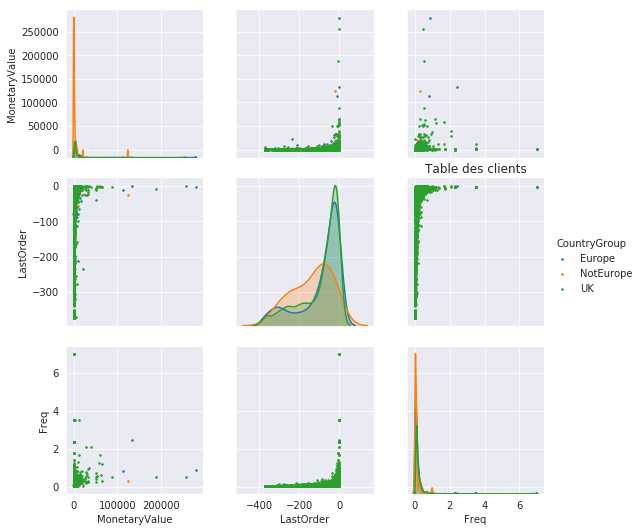

In [0]:
sns.pairplot(customers, hue="CountryGroup", plot_kws={'s': 3, "edgecolor": None})
plt.title("Table des clients")
plt.show()

In [0]:
customers.CountryGroup.value_counts()

UK           3916
Europe        377
NotEurope      41
Name: CountryGroup, dtype: int64

In [0]:
df[df.StockCode == "POST"].CountryGroup.value_counts()

Europe       1050
UK            136
NotEurope       6
Name: CountryGroup, dtype: int64

In [0]:
df[df.StockCode == "POST"].groupby('CountryGroup').TotalPrice.sum()

CountryGroup
Europe       66788.50
NotEurope      850.71
UK           -1408.57
Name: TotalPrice, dtype: float64

In [0]:
df.groupby('CountryGroup').TotalPrice.sum()

CountryGroup
Europe       1.343810e+06
NotEurope    2.161319e+05
UK           8.435498e+06
Name: TotalPrice, dtype: float64

In [0]:
df[df.CountryGroup == "Europe"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,TotalInvoice,CountryGroup,IsNanCust
2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347,Iceland,25.20,711.79,Europe,0
3,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347,Iceland,17.00,711.79,Europe,0
4,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347,Iceland,39.00,711.79,Europe,0
5,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,12347,Iceland,23.40,711.79,Europe,0
6,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.00,711.79,Europe,0
7,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.00,711.79,Europe,0
8,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.00,711.79,Europe,0
9,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.00,711.79,Europe,0
10,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.00,711.79,Europe,0
11,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.00,711.79,Europe,0


###Commandes

In [19]:
invoices = df.groupby('InvoiceNo').agg({
    'InvoiceDate': ['max', 
                    lambda x: (last_order - pd.Series.max(x)).days],
    'CustomerID': lambda x: pd.Series.mode(x, dropna=False)[0],
    'Country': lambda x: pd.Series.mode(x)[0],
    'CountryGroup': lambda x: pd.Series.mode(x)[0],
    'StockCode': [list, 
                  len],
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'N_orders': 'mean'	
})

invoices.columns = [
    'InvoiceDate', 'Recency', 'CustomerID', 'Country', 'CountryGroup',
    'Items', 'NumberOfLines', 'TotalQty', 'TotalPrice', 'N_orders'
]

invoices.head()

,InvoiceDate,Recency,CustomerID,Country,CountryGroup,Items,NumberOfLines,TotalQty,TotalPrice,N_orders
InvoiceNo,,,,,,,,,,
536365,2010-12-01,373,17850,United Kingdom,UK,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",20,474,1499.34,10.0
536367,2010-12-01,373,13047,United Kingdom,UK,"[84879, 22745, 22748, 22749, 22310, 84969, 226...",17,101,366.63,3.0
536370,2010-12-01,373,12583,France,Europe,"[22728, 22727, 22726, 21724, 21883, 10002, 217...",20,449,855.86,1.0
536371,2010-12-01,373,13748,United Kingdom,UK,[22086],1,80,204.00,1.0
536374,2010-12-01,373,15100,United Kingdom,UK,[21258],1,32,350.40,1.0


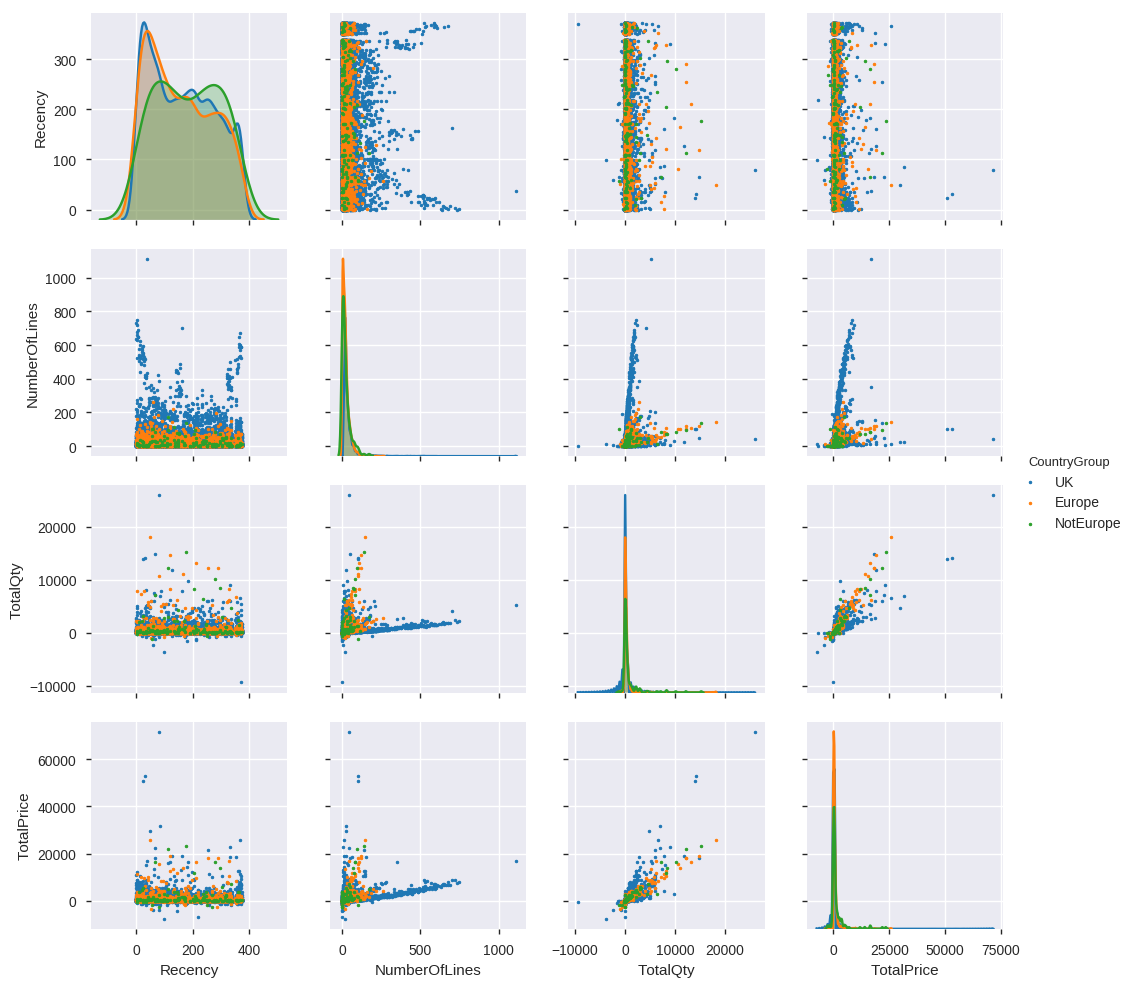

In [0]:
sns.pairplot(
    data=invoices[['Recency', 'NumberOfLines', 'TotalQty' ,'TotalPrice', 'CountryGroup']],
    hue='CountryGroup',
    plot_kws={'s': 3, "edgecolor": None},
)

In [0]:
pandas_profiling.ProfileReport(invoices).to_file("Invoices_EDA.html")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



In [0]:
files.download("Invoices_EDA.html")

In [0]:
crit1 = invoices.CustomerID.isna()
crit2 = invoices.Country == "United Kingdom"
print(invoices[~crit1 & crit2].TotalPrice.mean())
print(invoices[~crit1 & ~crit2].TotalPrice.mean())

392.6255013325564
778.5374085365852


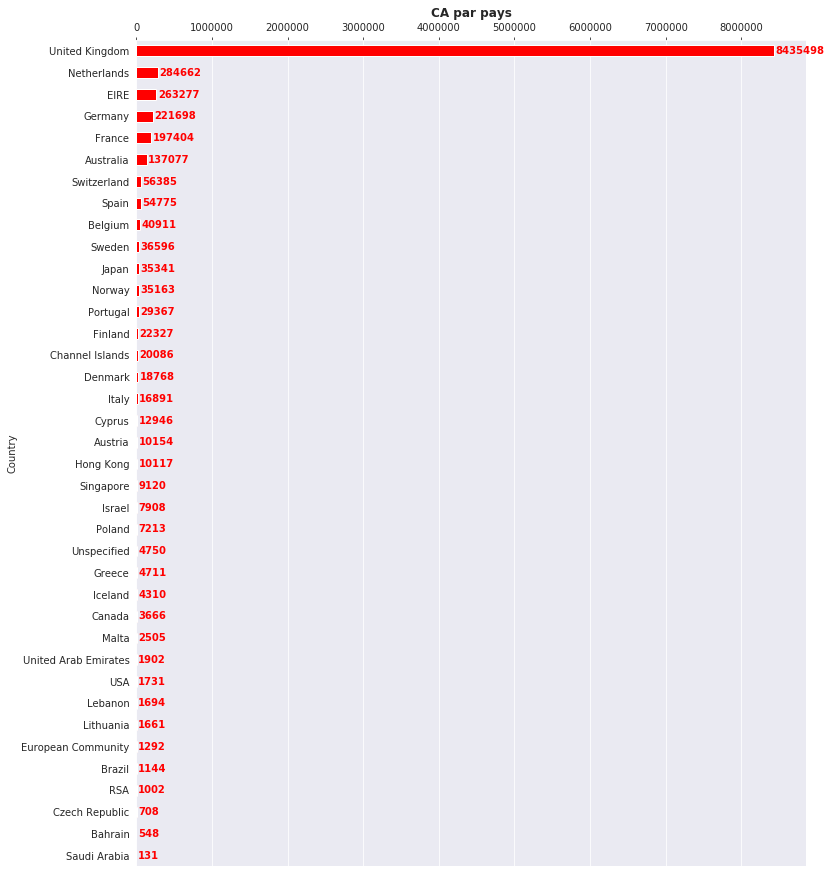

In [0]:
plot_barh(invoices.groupby('Country').TotalPrice.sum().sort_values(ascending=False),
          title="CA par pays")
plt.show()

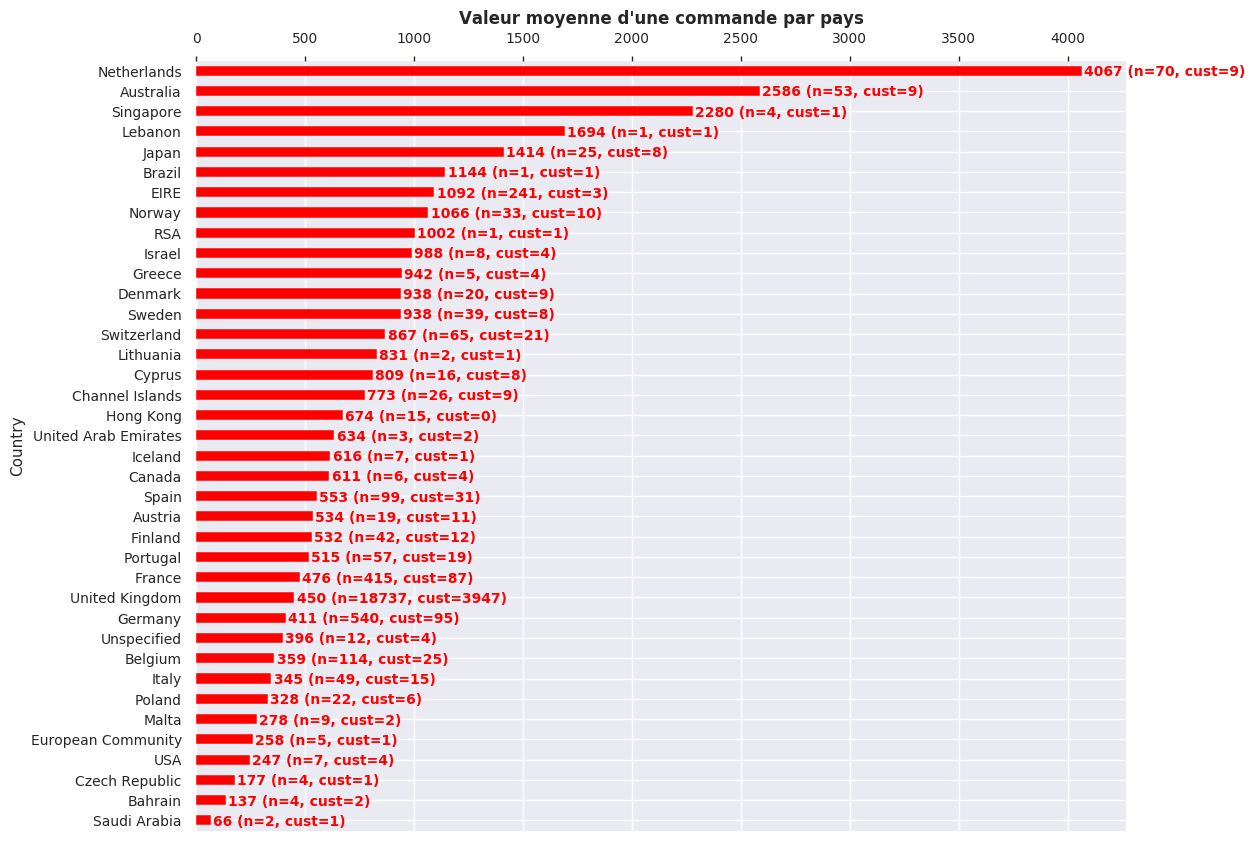

In [0]:
means = invoices.groupby('Country').TotalPrice.mean().sort_values(ascending=False)
n_cust = invoices.groupby('Country').CustomerID.nunique()
n_inv = invoices.groupby('Country').size()


fig, ax = plt.subplots(figsize=(12,10))
means.plot.barh(ax=ax, color='red')
plt.gca().invert_yaxis()
ax.set_title("Valeur moyenne d'une commande par pays", fontweight='bold')
ax.xaxis.tick_top()
for i, (country, val) in enumerate(means.items()):
    text = f"{str(round(val))} (n={n_inv.loc[country]}, cust={n_cust.loc[country]})"
    ax.text(val + 10, i + .25, text, color='red', fontweight='bold')

In [0]:
print(invoices[invoices.CountryGroup == "UK"].TotalPrice.mean())
print(invoices[invoices.CountryGroup == "Europe"].TotalPrice.mean())
print(invoices[invoices.CountryGroup == "NotEurope"].TotalPrice.mean())

450.0852626720786
707.6407056345446
1522.0554225352118


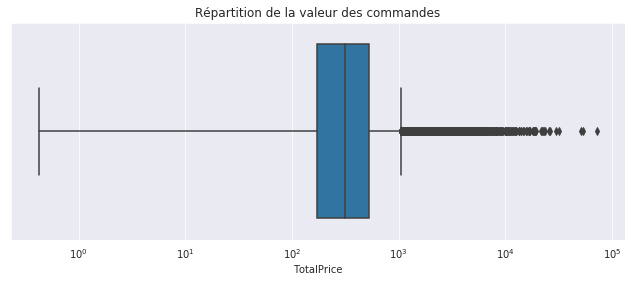

In [0]:
fig, ax = plt.subplots(figsize=(11, 4))
ax.set_xscale("log")
sns.boxplot(x='TotalPrice', data=invoices[invoices.TotalPrice > 0])
plt.title("Répartition de la valeur des commandes")
plt.show()

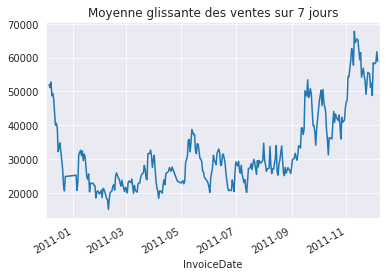

In [0]:
invoices.groupby('InvoiceDate').TotalPrice.sum().rolling(7, center=True).mean().plot()
plt.title("Moyenne glissante des ventes sur 7 jours")
plt.show()

###Produits

In [18]:
items = df.groupby('StockCode').agg({
    'Description': lambda x: pd.Series.mode(x)[0],
    'InvoiceNo': 'size',
    'CustomerID': 'size',
    'Quantity': 'sum',
    'TotalPrice': 'sum',
})

items.columns = ['Description', 'NumberOfOrders', 'NumberOfCustomers', 'TotalQty', 'TotalPrice']

items['AvgUnitPrice'] = items['TotalPrice'] / items['TotalQty'] 

items.head()

,Description,NumberOfOrders,NumberOfCustomers,TotalQty,TotalPrice,AvgUnitPrice
StockCode,,,,,,
10002,INFLATABLE POLITICAL GLOBE,71,71,860,759.89,0.883593
10080,GROOVY CACTUS INFLATABLE,22,22,303,119.09,0.393036
10120,DOGGY RUBBER,29,29,193,40.53,0.210000
10123C,HEARTS WRAPPING TAPE,3,3,5,3.25,0.650000
10124A,SPOTS ON RED BOOKCOVER TAPE,5,5,16,6.72,0.420000


In [0]:
items.nlargest(5, 'NumberOfOrders')

,Description,NumberOfOrders,NumberOfCustomers,TotalQty,TotalPrice,AvgUnitPrice
StockCode,,,,,,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2266,2266,35374,99846.98,2.822609
22423,REGENCY CAKESTAND 3 TIER,2116,2116,13023,164762.19,12.651631
85099B,JUMBO BAG RED RETROSPOT,2106,2106,47359,92356.03,1.950126
47566,PARTY BUNTING,1693,1693,18018,98302.98,5.455821
20725,LUNCH BAG RED RETROSPOT,1596,1596,18979,35187.31,1.854013


In [0]:
items.nlargest(5, 'TotalPrice')

,Description,NumberOfOrders,NumberOfCustomers,TotalQty,TotalPrice,AvgUnitPrice
StockCode,,,,,,
DOT,DOTCOM POSTAGE,707,707,705,206245.48,292.546780
22423,REGENCY CAKESTAND 3 TIER,2116,2116,13023,164762.19,12.651631
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2266,2266,35374,99846.98,2.822609
47566,PARTY BUNTING,1693,1693,18018,98302.98,5.455821
85099B,JUMBO BAG RED RETROSPOT,2106,2106,47359,92356.03,1.950126


In [0]:
items.nsmallest(5, 'TotalPrice')

,Description,NumberOfOrders,NumberOfCustomers,TotalQty,TotalPrice,AvgUnitPrice
StockCode,,,,,,
M,Manual,442,442,3161,-29701.64,-9.396280
D,Discount,64,64,-1194,-5696.22,4.770704
S,SAMPLES,19,19,-59,-3049.39,51.684576
79323W,"Unsaleable, destroyed.",1,1,-8,-54.00,6.750000
85063,CREAM SWEETHEART MAGAZINE RACK,2,2,-3,-46.85,15.616667


Des codes qui ne correspondent pas à des produits réels

In [0]:
order_fees_codes = [
    'POST', 'DOT', 'C2', # postage and carrier fees
    'M', 'S', 'D', # discounts or adjustments
    'GIFT_0001_10', 'GIFT_0001_20', 'GIFT_0001_30', 'GIFT_0001_40', 'GIFT_0001_50' # discounts
]
online_codes = ['DOT', 'GIFT_0001_10', 'GIFT_0001_20', 
                'GIFT_0001_30', 'GIFT_0001_40', 'GIFT_0001_50']

In [0]:
print(df[df.StockCode.isin(online_codes)].CustomerID.value_counts(dropna=False))
print(df[df.StockCode.isin(online_codes)].StockCode.value_counts(dropna=False))

NaN      722
14096     16
Name: CustomerID, dtype: int64
DOT             707
GIFT_0001_20      9
GIFT_0001_10      8
GIFT_0001_30      7
GIFT_0001_50      4
GIFT_0001_40      3
Name: StockCode, dtype: int64


In [0]:
len_codes = df.StockCode.apply(len)
df.drop_duplicates('StockCode').StockCode.apply(len).value_counts()

5     2878
6      925
8        6
12       5
1        3
4        2
9        1
7        1
3        1
2        1
Name: StockCode, dtype: int64

In [0]:
df[~len_codes.between(5,6)].groupby('StockCode').Description.apply(lambda x: pd.Series.mode(x, dropna=False)[0])

StockCode
15056BL                    EDWARDIAN PARASOL BLACK
C2                                        CARRIAGE
D                                         Discount
DCGS0003                       BOXED GLASS ASHTRAY
DCGS0004                HAYNES CAMPER SHOULDER BAG
DCGS0069                     OOH LA LA DOGS COLLAR
DCGS0070                     CAMOUFLAGE DOG COLLAR
DCGS0076              SUNJAR LED NIGHT NIGHT LIGHT
DCGSSBOY                            BOYS PARTY BAG
DCGSSGIRL                          GIRLS PARTY BAG
DOT                                 DOTCOM POSTAGE
GIFT_0001_10    Dotcomgiftshop Gift Voucher £10.00
GIFT_0001_20    Dotcomgiftshop Gift Voucher £20.00
GIFT_0001_30    Dotcomgiftshop Gift Voucher £30.00
GIFT_0001_40    Dotcomgiftshop Gift Voucher £40.00
GIFT_0001_50    Dotcomgiftshop Gift Voucher £50.00
M                                           Manual
PADS                    PADS TO MATCH ALL CUSHIONS
POST                                       POSTAGE
S                    

In [0]:
for item in items.nlargest(5, 'NumberOfOrders').index:
    print(f"{item}:")
    display(df[df.StockCode==item].groupby('CountryGroup').agg({
        'UnitPrice': 'mean',
        'Quantity': 'mean'
    }))
    print("")

85123A:


,UnitPrice,Quantity
CountryGroup,,
Europe,2.866049,22.955556
NotEurope,2.850000,14.500000
UK,-inf,15.308471



22423:


,UnitPrice,Quantity
CountryGroup,,
Europe,12.301354,7.674342
NotEurope,12.013636,14.272727
UK,14.091234,5.796648



85099B:


,UnitPrice,Quantity
CountryGroup,,
Europe,2.013537,26.843537
NotEurope,1.975000,31.250000
UK,2.520608,22.123526



47566:


,UnitPrice,Quantity
CountryGroup,,
Europe,4.844737,11.052632
NotEurope,4.650000,29.562500
UK,5.842121,10.434104



20725:


,UnitPrice,Quantity
CountryGroup,,
Europe,1.631366,24.571429
NotEurope,1.592857,33.285714
UK,2.181612,10.244194


In [0]:
item_price = df.groupby(['StockCode', 'InvoiceNo']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
})
item_price['CustomerID'] = item_price.index.get_level_values(1).map(dict(invoices['CustomerID']))
item_price['CountryGroup'] = item_price.index.get_level_values(1).map(dict(invoices['CountryGroup']))

In [0]:
item_price[item_price.CustomerID.isna()].CountryGroup.value_counts()

UK           130599
Europe          913
NotEurope       520
Name: CountryGroup, dtype: int64

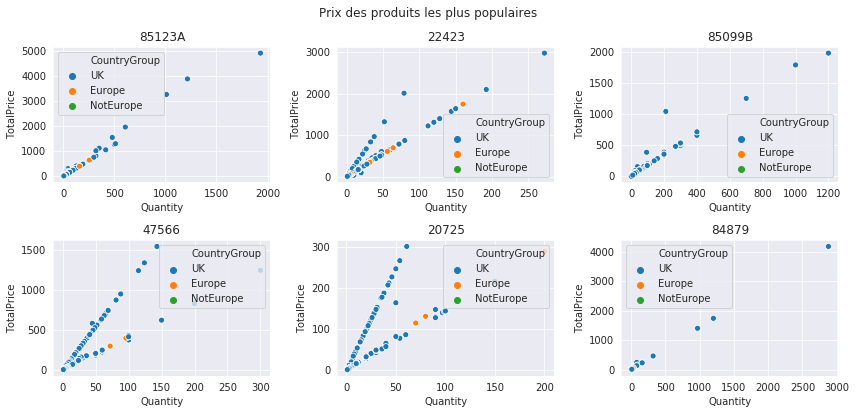

In [0]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for i, item in enumerate(items.nlargest(6, 'NumberOfOrders').index):
    crit1 = item_price.index.get_level_values(0)==item
    crit2 = item_price['Quantity'] > 0
    sns.scatterplot(data=item_price[crit1 & crit2],
                    x='Quantity', y='TotalPrice', hue='CountryGroup', 
                    ax=ax.flat[i])
    ax.flat[i].set_title(item)

plt.suptitle("Prix des produits les plus populaires")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Tous les clients ne paient pas le même prix unitaire pour des produits équivalents

In [0]:
crit1 = item_price.index.get_level_values(0)=="47566"
crit2 = item_price['Quantity'] > 0
item_price_cust = item_price[crit1 & crit2].fillna({'CustomerID': 'nan'}) \
                    .groupby(['CustomerID', 'CountryGroup']).sum()
item_price_cust['AvgPrice'] = (item_price_cust['TotalPrice'] / item_price_cust['Quantity']).round(2)
item_price_cust.head()

,,Quantity,TotalPrice,AvgPrice
CustomerID,CountryGroup,,,
12359,Europe,5,23.25,4.65
12362,Europe,4,19.80,4.95
12364,Europe,4,19.80,4.95
12370,Europe,1,4.65,4.65
12381,Europe,4,19.80,4.95


In [0]:
item_price_cust.AvgPrice.value_counts()

4.95     597
4.15      28
4.65      26
4.78       6
4.88       6
4.83       3
4.80       3
4.91       3
4.30       3
4.02       2
4.52       2
4.92       2
4.89       2
4.90       2
4.93       2
4.24       1
4.38       1
10.25      1
10.79      1
4.23       1
4.46       1
3.97       1
4.81       1
4.09       1
4.18       1
4.70       1
4.21       1
4.11       1
4.17       1
4.07       1
4.34       1
4.57       1
4.85       1
4.19       1
4.45       1
4.84       1
4.86       1
3.79       1
3.75       1
Name: AvgPrice, dtype: int64

In [0]:
full_print(item_price_cust[~item_price_cust.AvgPrice.between(4.66, 5.1)].sort_values('Quantity', ascending=False), rows=None)

,,Quantity,TotalPrice,AvgPrice
CustomerID,CountryGroup,,,
nan,UK,2981,30549.15,10.25
17723,UK,750,3112.50,4.15
14680,UK,600,2490.00,4.15
17511,UK,500,2035.00,4.07
16013,UK,450,1707.50,3.79
13001,UK,450,1847.50,4.11
13113,UK,365,1522.25,4.17
13694,UK,350,1432.50,4.09
15039,UK,320,1328.00,4.15


In [0]:
df['IsNanCust'] = df.CustomerID.isna().astype('uint8').astype('category')
item_nan_cust = df.groupby(['StockCode', 'IsNanCust']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
})
item_nan_cust['AvgPrice'] = item_nan_cust['TotalPrice'] / item_nan_cust ['Quantity']
item_nan_cust = item_nan_cust.unstack()
item_nan_cust.dropna(subset=[('AvgPrice', 0), ('AvgPrice', 1)], inplace=True)

item_nan_cust.head()

Quantity        TotalPrice          AvgPrice          
IsNanCust        0      1          0       1         0         1
StockCode                                                       
10002        823.0   37.0     699.55   60.34  0.850000  1.630811
10080        291.0   12.0     114.41    4.68  0.393162  0.390000
10125       1226.0   70.0     930.30   64.54  0.758809  0.922000
10133       2374.0  483.0    1139.41  400.61  0.479954  0.829420
10135       1937.0  293.0    1785.44  420.70  0.921755  1.435836

In [0]:
crit1 = ~item_nan_cust.index.isin(order_fees_codes)
crit2 = item_nan_cust[('AvgPrice', 0)] > 0
crit3 = item_nan_cust[('AvgPrice', 1)] > 0
filters = crit1 & crit2 & crit3

item_nan_cust = item_nan_cust[filters].xs('AvgPrice', axis=1).sort_values(1)
item_nan_cust.columns=['KnownCust', 'UnknownCust']

full_print(item_nan_cust, rows=10)

,KnownCust,UnknownCust
StockCode,,
84199,0.210000,0.210000
85230B,0.258101,0.290000
72225C,0.264400,0.290000
21829,0.206209,0.366156
16236,0.205679,0.376972
...,...,...
22764,24.950000,49.960000
84078A,36.518323,57.864655
84616,29.950000,58.290000


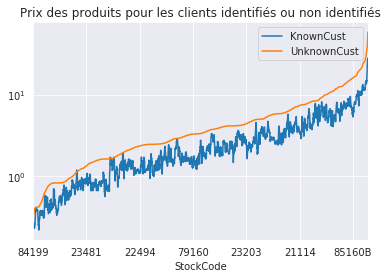

In [0]:
item_nan_cust.rolling(10).mean().plot()
plt.yscale('log')
plt.title("Prix des produits pour les clients identifiés ou non identifiés")
plt.show()

In [0]:
mean_discount = 1 - (item_nan_cust.KnownCust / item_nan_cust.UnknownCust).mean()
print("Réduction moyenne par article pour les clients connus : "
      f"{mean_discount * 100:.1f}%")

Réduction moyenne par article pour les clients connus : 40.5%


In [0]:
invoices[invoices.CustomerID.isna()].describe()

,Recency,NumberOfLines,TotalQty,TotalPrice
count,1550.000000,1550.000000,1550.000000,1550.000000
mean,191.190968,85.181935,269.594194,1088.777626
std,109.576282,133.741068,669.345517,2590.797321
min,0.000000,1.000000,-811.000000,-2653.950000
25%,99.000000,2.000000,3.000000,10.237500
50%,191.000000,25.000000,54.000000,309.155000
75%,283.000000,130.000000,371.750000,1506.425000
max,372.000000,1108.000000,14149.000000,52940.940000


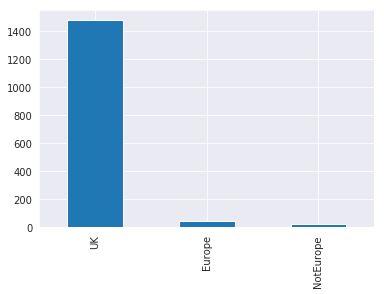

In [0]:
invoices[invoices.CustomerID.isna()].CountryGroup.value_counts().plot.bar()

In [0]:
invoices[~invoices.CustomerID.isna()].describe()

,Recency,NumberOfLines,TotalQty,TotalPrice
count,19233.000000,19233.000000,19233.000000,19233.000000
mean,162.113139,20.398482,254.413196,431.957274
std,112.388562,24.582504,618.372961,1147.609698
min,0.000000,1.000000,-9360.000000,-7460.950000
25%,59.000000,5.000000,54.000000,123.750000
50%,153.000000,14.000000,141.000000,282.660000
75%,255.000000,27.000000,278.000000,450.060000
max,373.000000,541.000000,25930.000000,71601.440000


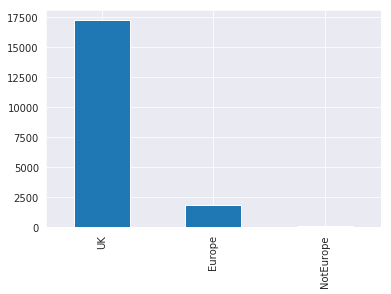

In [0]:
invoices[~invoices.CustomerID.isna()].CountryGroup.value_counts().plot.bar()

D'un côté les clients inconnus semblent être des consommateurs directs puisqu'ils payent en moyenne un prix plus élevés par article. Ils sont aussi beaucoup plus souvent basés au Royaume-Uni que les clients connus. De l'autre côté, ils commandent plus d'articles différents et pour une valeur plus de 2 fois supérieure.

Cela parait totalement contradictoire et il est difficile d'expliquer de telles différences. Peut-être que les commandes de clients inconnus ont été regroupées au préalable.

####Sauvegarde des données

In [0]:
items.to_csv("items.csv")
invoices.to_csv("invoices.csv")
customers.to_csv("customers.csv")

In [0]:
files.download("items.csv")
files.download("invoices.csv")
files.download("customers.csv")

####Rechargement des données

####Analyse des descriptions

In [0]:
colors_list = [
    "amaranth",
    "amber",
    "amethyst",
    "azure",
    "beige",
    "black",
    "blue",
    "brown",
    "burgundy",
    "byzantium",
    "carmine",
    "cerise",
    "cerulean",
    "copper",
    "coral",
    "crimson",
    "cyan",
    "emerald",
    "erin",
    "gold",
    "gray",
    "green",
    "harlequin",
    "indigo",
    "ivory",
    "jade",
    "lilac",
    "magenta",
    "maroon",
    "mauve",
    "ochre",
    "orange",
    "pear",
    "periwinkle",
    "pink",
    "plum",
    "puce",
    "purple",
    "red",
    "rose",
    "ruby",
    "salmon",
    "sapphire",
    "scarlet",
    "silver",
    "tan",
    "taupe",
    "teal",
    "turquoise",
    "ultramarine",
    "violet",
    "viridian",
    "white",
    "yellow",
]

custom_stopwords = [
    "set",
    "large",
    "small",
]

In [0]:
from wordcloud import WordCloud, STOPWORDS

def clean_text(series):
    series = series.str.replace("[^a-zA-Z\s]+", " ", regex=True)
    series = series.str.replace("  ", " ")
    series = series.str.strip()
    series = series.str.lower()
    series = series.str.split(" ", expand=False)
    series = series.apply(lambda l: [x for x in l if x not in STOPWORDS])
    series = series.apply(lambda l: [x for x in l if x not in colors_list])
    series = series.apply(lambda l: [x for x in l if x not in custom_stopwords])
    series = series.apply(lambda l: [x for x in l if len(x) > 1])
    series = series.apply(lambda l: " ".join(l))

    return series

clean_text(items['Description']).head()

StockCode
10002     inflatable political globe
10080       groovy cactus inflatable
10120                   doggy rubber
10123C          hearts wrapping tape
10124A          spots bookcover tape
Name: Description, dtype: object

In [0]:
word_count = {}
for desc in clean_text(items['Description']):
    for word in desc.split(" "):
        if len(word) > 1:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

for key in sorted(word_count, key=word_count.get, reverse=True)[:100]:
    print(f"{key}: {word_count[key]}")

heart: 216
vintage: 196
glass: 161
bag: 157
christmas: 141
box: 127
design: 119
flower: 110
metal: 107
holder: 105
light: 104
necklace: 102
candle: 97
hanging: 96
retrospot: 94
decoration: 93
card: 84
cake: 80
paper: 77
wall: 76
bracelet: 72
garden: 71
earrings: 69
pack: 67
mug: 66
polkadot: 65
sign: 65
cover: 64
wrap: 60
art: 58
egg: 58
assorted: 57
crystal: 57
mini: 56
gift: 55
tree: 54
tea: 54
love: 52
bowl: 52
cushion: 52
star: 52
cards: 52
cream: 51
mirror: 49
wooden: 47
ring: 47
zinc: 47
home: 47
easter: 47
frame: 46
clock: 43
party: 42
ceramic: 42
paisley: 41
french: 41
bird: 41
tin: 40
bottle: 40
diamante: 39
hook: 39
candles: 39
garland: 39
bead: 39
key: 38
wood: 38
charm: 38
photo: 37
butterfly: 37
dolly: 36
tray: 36
enamel: 36
girl: 35
antique: 35
lights: 34
felt: 34
fairy: 33
round: 33
colour: 32
tile: 32
sweetheart: 32
jar: 32
spaceboy: 32
hearts: 31
letter: 31
notebook: 31
painted: 31
cup: 31
drop: 31
stand: 30
drawer: 30
birthday: 29
hot: 29
rabbit: 28
retro: 28
doormat:

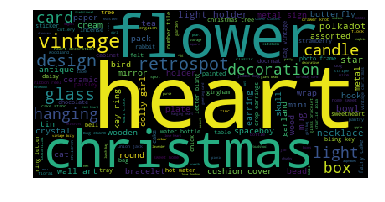

In [0]:
text = " ".join(clean_text(items['Description']).values)

wc = WordCloud(random_state=0).generate(text)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [0]:
tfidf = TfidfVectorizer()
mat = tfidf.fit_transform(clean_text(items['Description']))
mat.shape

(3823, 1926)

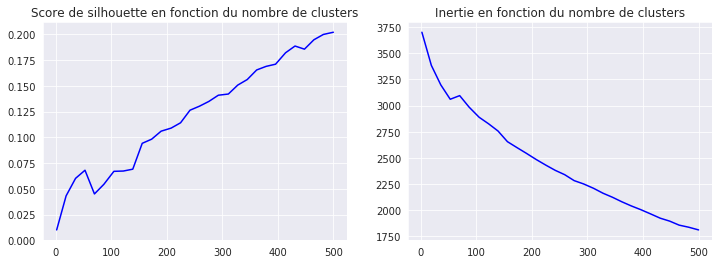

In [0]:
n_clusters = np.linspace(2, 500, 30, dtype=int)

kmean = {}
silhouette = {}
inertia = {}

for k in n_clusters:
    km = KMeans(k, n_init=10, random_state=0)
    labels = km.fit_predict(mat)
    kmean[k] = km
    silhouette[k] = silhouette_score(mat, labels)
    inertia[k] = km.inertia_
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(n_clusters, [silhouette[k] for k in n_clusters], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(n_clusters, [inertia[k] for k in n_clusters], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

plt.show()

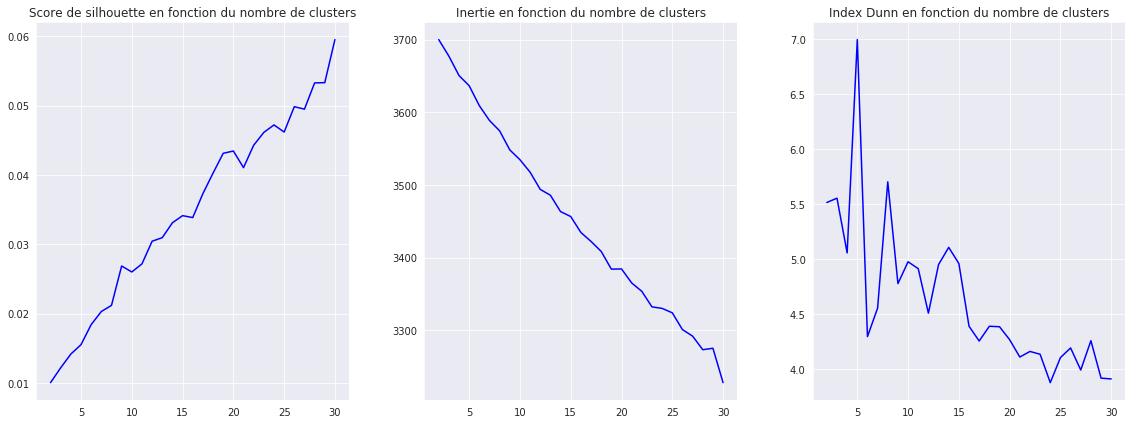

In [0]:
n_clusters = list(range(2, 31))

dense_mat = mat.toarray()

kmean = {}
silhouette = {}
inertia = {}
dunn_index = {}

for k in n_clusters:
    km = KMeans(k, n_init=10, random_state=0)
    labels = km.fit_predict(mat)
    kmean[k] = km
    silhouette[k] = silhouette_score(mat, labels)
    inertia[k] = km.inertia_
    dunn_index[k] = davies_bouldin_score(dense_mat, labels)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

ax[0].plot(n_clusters, [silhouette[k] for k in n_clusters], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(n_clusters, [inertia[k] for k in n_clusters], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

ax[2].plot(n_clusters, [dunn_index[k] for k in n_clusters], 'b-')
ax[2].set_title("Index Dunn en fonction du nombre de clusters")

plt.tight_layout()
plt.show()

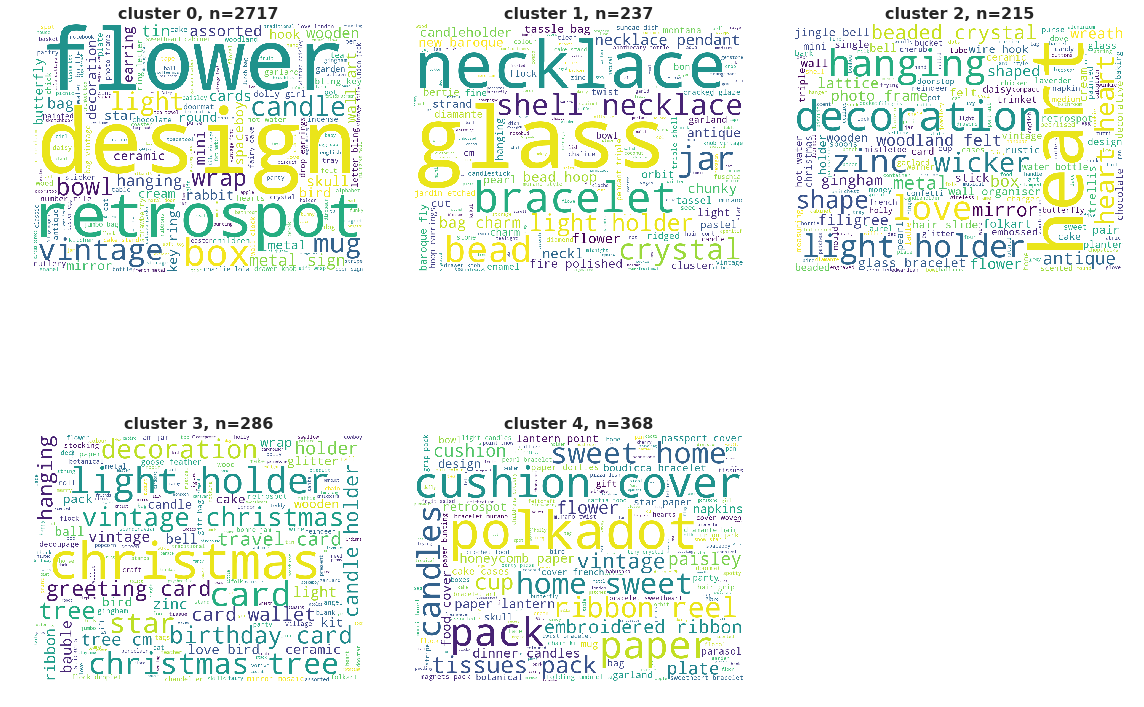

In [0]:
k = 5
km = KMeans(k, n_init=10, random_state=0)
items_clust = km.fit_predict(mat)
items['Cluster'] = items_clust

cluster_size = items['Cluster'].value_counts(sort=False)

fig, axes = plt.subplots(2, 3, figsize=(16, 12))

for cluster, ax in enumerate(axes.flatten()):
    if cluster in range(k):
        text = " ".join(clean_text(items['Description'])[items_clust == cluster].values)
        wc = WordCloud(background_color='white', width=1200, height=900, random_state=0)
        wc.generate(text)
        ax.imshow(wc)
        ax.axis("off")
        size = cluster_size.loc[cluster]
        ax.set_title(f"cluster {cluster}, n={size}", weight='bold', size=16)
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

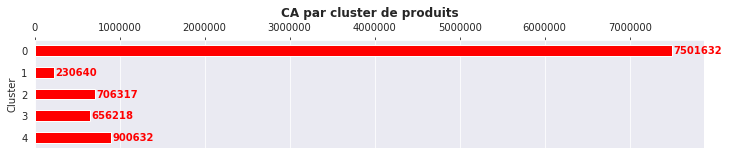

In [0]:
plot_barh(items.groupby('Cluster').TotalPrice.sum(),
          title="CA par cluster de produits")
plt.show()

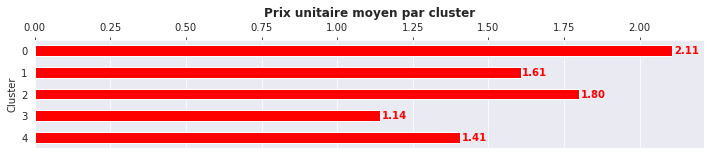

In [0]:
data = (items.groupby('Cluster').TotalPrice.sum() /
        items.groupby('Cluster').TotalQty.sum())
plot_barh(data, title="Prix unitaire moyen par cluster", fmt='.2f')
plt.show()

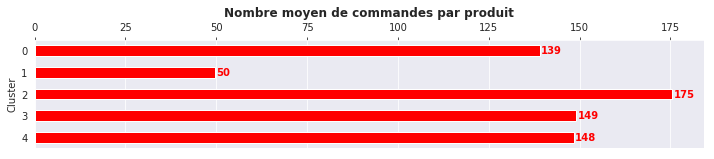

In [0]:
plot_barh(items.groupby('Cluster').NumberOfOrders.mean(),
          title="Nombre moyen de commandes par produit")
plt.show()

In [0]:
items['Cluster'] = items_clust

spent_by_clust = df.copy()
spent_by_clust = spent_by_clust[spent_by_clust['TotalPrice'] > 0]
spent_by_clust['ItemCluster'] = df['StockCode'].map(dict(items['Cluster']))
spent_by_clust = spent_by_clust.groupby(['InvoiceNo', 'ItemCluster']).TotalPrice.sum()
spent_by_clust = spent_by_clust.unstack().fillna(0)
basket_price = spent_by_clust.sum(axis=1)

spent_by_clust = spent_by_clust.divide(basket_price, axis=0)
spent_by_clust['TotalPrice'] = basket_price

spent_by_clust['InvoiceDate'] = spent_by_clust.index.map(invoices['InvoiceDate'])
spent_by_clust['CustomerID'] = spent_by_clust.index.map(invoices['CustomerID'])
spent_by_clust['Country'] = spent_by_clust.index.map(invoices['Country'])
spent_by_clust['CountryGroup'] = spent_by_clust.index.map(invoices['CountryGroup'])

spent_by_clust.sort_values('InvoiceDate', inplace=True)

spent_by_clust.head()

ItemCluster,0,1,2,3,4,TotalPrice,InvoiceDate,CustomerID,Country,CountryGroup
InvoiceNo,,,,,,,,,,
536367,0.864577,0.0,0.086736,0.000000,0.048687,366.63,2010-12-01 08:35:00,13047,United Kingdom,UK
536370,0.964948,0.0,0.000000,0.035052,0.000000,855.86,2010-12-01 08:45:00,12583,France,Europe
536371,0.000000,0.0,0.000000,1.000000,0.000000,204.00,2010-12-01 09:00:00,13748,United Kingdom,UK
536374,1.000000,0.0,0.000000,0.000000,0.000000,350.40,2010-12-01 09:09:00,15100,United Kingdom,UK
536376,0.503650,0.0,0.496350,0.000000,0.000000,328.80,2010-12-01 09:32:00,15291,United Kingdom,UK


In [0]:
spent_by_clust.describe()

ItemCluster,0,1,2,3,4,BasketPrice
count,18090.000000,18090.000000,18090.000000,18090.000000,18090.000000,18090.000000
mean,0.735605,0.032004,0.074891,0.065437,0.092063,565.916320
std,0.231064,0.105144,0.132668,0.131423,0.139807,1394.166216
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.380000
25%,0.626178,0.000000,0.000000,0.000000,0.000000,172.250000
50%,0.782991,0.000000,0.014603,0.000000,0.051260,312.525000
75%,0.905741,0.015451,0.098112,0.074690,0.123545,525.010000
max,1.000000,1.000000,1.000000,1.000000,1.000000,71601.440000


In [0]:
customers_1st_order = spent_by_clust.sort_values('InvoiceDate', ascending=True)

crit1 = ~customers_1st_order.CustomerID.isna()
crit2 = customers_1st_order.TotalPrice > 0

customers_1st_order = customers_1st_order[crit1 & crit2].reset_index(drop=False)

customers_1st_order = customers_1st_order.drop_duplicates('CustomerID')
customers_1st_order = customers_1st_order.set_index('CustomerID').sort_index()

customers_1st_order = customers_1st_order[['InvoiceNo']]
customers_1st_order = customers_1st_order.merge(
    spent_by_clust, left_on='InvoiceNo', right_index=True
)

customers_1st_order['CustomerCluster'] = customers_1st_order.index.map(cust_to_clust)

customers_1st_order.head()

ItemCluster,InvoiceNo,0,1,2,3,4,TotalPrice,InvoiceDate,CustomerID,Country,CountryGroup,CustomerCluster
CustomerID,,,,,,,,,,,,
12347,537626,0.818767,0.054791,0.027817,0.035404,0.063221,711.79,2010-12-07 14:57:00,12347,Iceland,Europe,1
12348,539318,0.474462,0.000000,0.077957,0.071237,0.376344,892.80,2010-12-16 19:09:00,12348,Finland,Europe,0
12349,577609,0.848551,0.017183,0.087992,0.005804,0.040471,1757.55,2011-11-21 09:51:00,12349,Italy,Europe,1
12350,543037,0.804426,0.000000,0.000000,0.000000,0.195574,334.40,2011-02-02 16:01:00,12350,Norway,Europe,0
12352,544156,0.939798,0.000000,0.000000,0.000000,0.060202,296.50,2011-02-16 12:33:00,12352,Norway,Europe,1


In [0]:
columns = ['TotalPrice'] + list(range(5)) + ['CustomerCluster']
data = customers_1st_order[columns]

price_scaler = StandardScaler()
data['TotalPrice'] = price_scaler.fit_transform(data[['TotalPrice']])

data.head()

ItemCluster,TotalPrice,0,1,2,3,4,CustomerCluster
CustomerID,,,,,,,
12347,0.370921,0.818767,0.054791,0.027817,0.035404,0.063221,1
12348,0.609307,0.474462,0.000000,0.077957,0.071237,0.376344,0
12349,1.748165,0.848551,0.017183,0.087992,0.005804,0.040471,1
12350,-0.126094,0.804426,0.000000,0.000000,0.000000,0.195574,0
12352,-0.176008,0.939798,0.000000,0.000000,0.000000,0.060202,1


In [0]:
dtrain, dtest = train_test_split(data, test_size=0.2, random_state=0)

X_train = dtrain.drop(columns='CustomerCluster')
X_test = dtest.drop(columns='CustomerCluster')

OHE = OneHotEncoder(categories='auto', sparse=False)
OHE.fit(data[['CustomerCluster']])

y_train = OHE.transform(dtrain[['CustomerCluster']])
y_test = OHE.transform(dtest[['CustomerCluster']])

y_train = dtrain['CustomerCluster']
y_test = dtest['CustomerCluster']

              precision    recall  f1-score   support

           0       0.56      0.71      0.63       427
           1       0.61      0.46      0.52       428
           2       0.50      0.17      0.25        12

    accuracy                           0.58       867
   macro avg       0.56      0.45      0.47       867
weighted avg       0.58      0.58      0.57       867



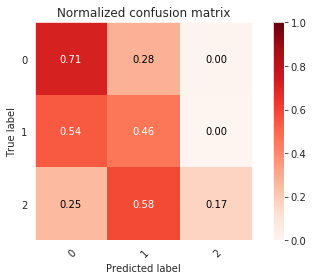

In [0]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

In [0]:
customers.head()

,Country,CountryGroup,MonetaryValue,LastOrder,Freq
CustomerID,,,,,
12347,Iceland,Europe,4310.00,-2.0,0.133880
12348,Finland,Europe,1797.24,-75.0,0.078431
12349,Italy,Europe,1757.55,-19.0,0.388889
12350,Norway,Europe,334.40,-310.0,0.022654
12352,Norway,Europe,1545.41,-36.0,0.165541


In [0]:
no_cancellation = df[df.TotalPrice > 0.001].copy()
no_cancellation.sort_values(['InvoiceDate', 'InvoiceNo', 'StockCode'], 
                            inplace=True, ascending=True)



def pipeline(n_items_clusters=5, n_days=0, 
             cust_train=None, cust_test=None, 
             classifier=LogisticRegression, **clf_kw):
    

    items_km = KMeans(n_items_clusters, n_init=10, random_state=0)
    items_clust = items_km.fit_predict(mat)

    items_to_clust = dict(zip(items.index, items_clust))

    no_cancellation['ItemCluster'] = no_cancellation['StockCode'].map(items_to_clust)

    data = no_cancellation.groupby(['InvoiceNo', 'ItemCluster']).TotalPrice.sum()
    data = data.unstack().fillna(0)
    data['TotalPrice'] = data.sum(axis=1)

    data['InvoiceDate'] = data.index.map(invoices['InvoiceDate'])
    data['CustomerID'] = data.index.map(invoices['CustomerID'])

    data['CustFirstOrderDate'] = data['CustomerID'].map(customers['FirstOrderDate'])
    data['DaysSince1stOrder'] = (data['InvoiceDate'] - data['CustFirstOrderDate']).dt.days

    data = data[data['DaysSince1stOrder'] <= n_days]
    data = data.drop(columns=['InvoiceDate', 'CustFirstOrderDate', 'DaysSince1stOrder'])
    data['N_orders'] = data.index.map(invoices['N_orders'])

    data = data.groupby('CustomerID').sum()

    
    data[list(range(n_items_clusters))] = data[list(range(n_items_clusters))].div(data['TotalPrice'].values, axis=0)

    dtrain = data[data.index.isin(cust_train)]
    dtest = data[data.index.isin(cust_test)]

    y_train = dtrain.index.map(cust_to_clust)
    y_test = dtest.index.map(cust_to_clust)

    scaler = StandardScaler().fit(dtrain[['TotalPrice', 'N_orders']])
    dtrain[['TotalPrice', 'N_orders']] = scaler.transform(dtrain[['TotalPrice', 'N_orders']])
    dtest[['TotalPrice', 'N_orders']] = scaler.transform(dtest[['TotalPrice', 'N_orders']])

    clf = classifier(**clf_kw)
    clf.fit(dtrain, y_train)
    y_pred = clf.predict(dtest)

    return y_pred, y_test

In [0]:
cust_train, cust_test = train_test_split(customers.index, test_size=0.2, random_state=0)

days = [0, 1, 3, 7, 10, 14, 21, 30, 45, 60, 90, 120, 180]
items_clusters = np.linspace(2, 30, num=6, dtype=int)

f1_scores = {}
for n_items_clusters in items_clusters:
    for n_days in days:
        
        y_pred, y_test = pipeline(
            n_items_clusters, n_days, 
            cust_train=cust_train, cust_test=cust_test,
            classifier=LogisticRegression,
            **dict(solver='lbfgs', multi_class='auto', max_iter=10000))
        
        f1_scores[(n_items_clusters, n_days)] = f1_score(y_pred, y_test, average='macro')

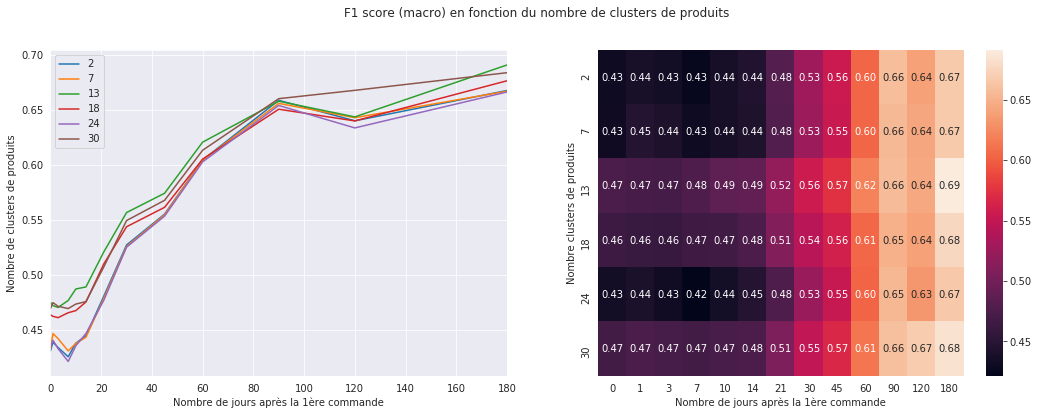

In [0]:
scores = pd.DataFrame(index=items_clusters, columns=days, dtype='float64')
for tup, val in f1_scores.items():
    scores.loc[tup[0], tup[1]] = val

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.suptitle("F1 score (macro) en fonction du nombre de clusters de produits")

scores.T.plot(ax=ax[0])
ax[0].set_xlabel("Nombre de jours après la 1ère commande")
ax[0].set_ylabel("Nombre de clusters de produits")

sns.heatmap(scores, annot=True, fmt='.2f', ax=ax[1])
ax[1].set_xlabel("Nombre de jours après la 1ère commande")
ax[1].set_ylabel("Nombre clusters de produits")

plt.show()

Les meilleurs résultats sont obtenus avec 13 clusters de produits. On cherche le nombre exact de clusters qui optimise la performance de la régression logistique.

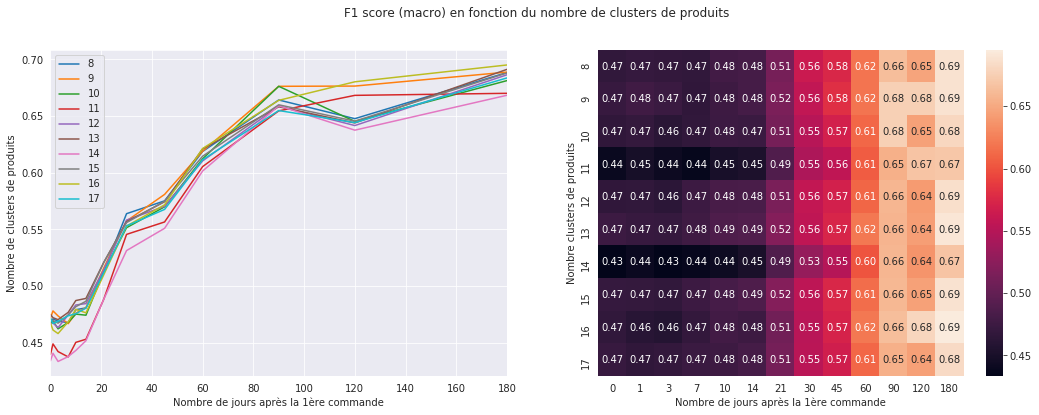

In [0]:
cust_train, cust_test = train_test_split(customers.index, test_size=0.2, random_state=0)

days = [0, 1, 3, 7, 10, 14, 21, 30, 45, 60, 90, 120, 180]
items_clusters = range(8,18)

for n_items_clusters in items_clusters:
    for n_days in days:
        
        y_pred, y_test = pipeline(
            n_items_clusters, n_days, 
            cust_train=cust_train, cust_test=cust_test,
            classifier=LogisticRegression,
            **dict(solver='lbfgs', multi_class='auto', max_iter=10000))
        
        f1_scores[(n_items_clusters, n_days)] = f1_score(y_pred, y_test, average='macro')
        
scores = pd.DataFrame(index=items_clusters, columns=days, dtype='float64')
for tup, val in f1_scores.items():
    scores.loc[tup[0], tup[1]] = val

scores = scores.loc[range(8,18)]

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.suptitle("F1 score (macro) en fonction du nombre de clusters de produits")

scores.T.plot(ax=ax[0])
ax[0].set_xlabel("Nombre de jours après la 1ère commande")
ax[0].set_ylabel("Nombre de clusters de produits")

sns.heatmap(scores, annot=True, fmt='.2f', ax=ax[1])
ax[1].set_xlabel("Nombre de jours après la 1ère commande")
ax[1].set_ylabel("Nombre clusters de produits")

plt.show()

On gardera 9 clusters de produits.

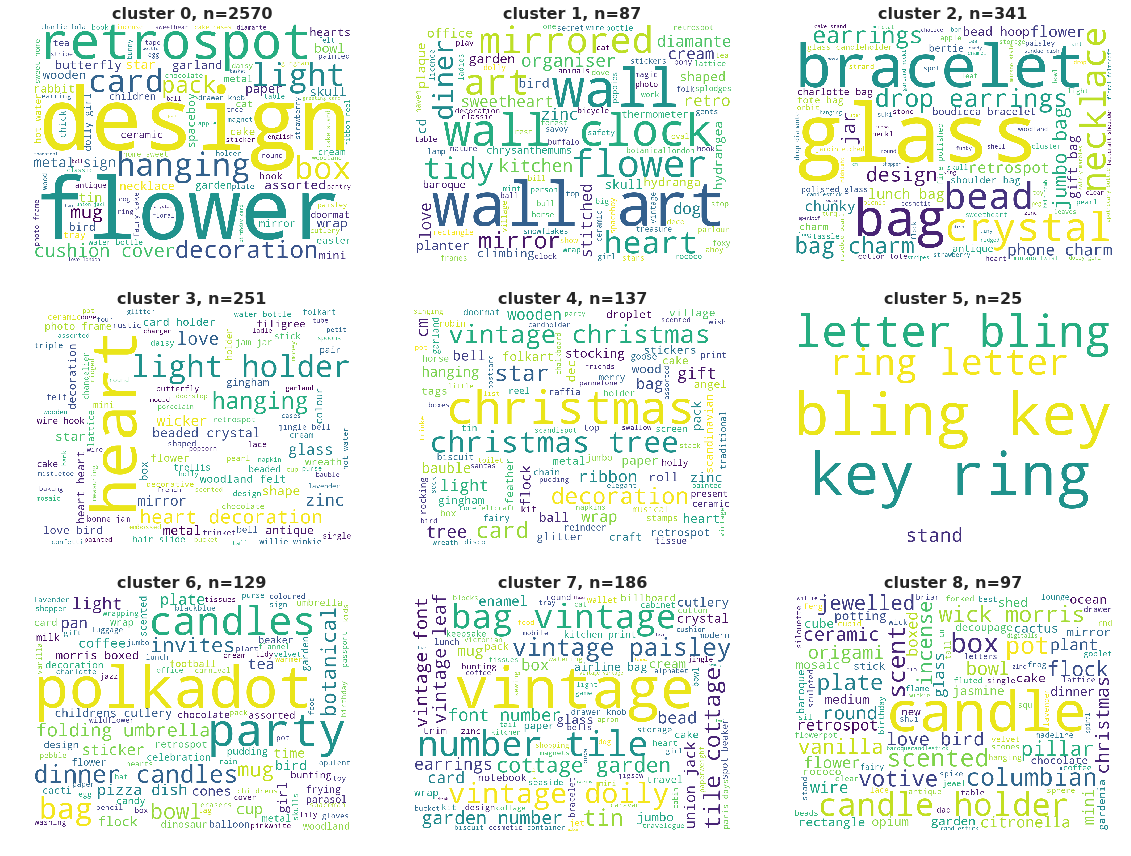

In [0]:
k = 9
km = KMeans(k, n_init=10, random_state=0)
items_clust = km.fit_predict(mat)
items['Cluster'] = items_clust

cluster_size = items['Cluster'].value_counts(sort=False)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for cluster, ax in enumerate(axes.flatten()):
    if cluster in range(k):
        text = " ".join(clean_text(items['Description'])[items_clust == cluster].values)
        wc = WordCloud(background_color='white', width=1200, height=900,
                       max_words=100, random_state=0)
        wc.generate(text)
        ax.imshow(wc)
        ax.axis("off")
        size = cluster_size.loc[cluster]
        ax.set_title(f"cluster {cluster}, n={size}", weight='bold', size=16)
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

###Tests sur différents splits des clients

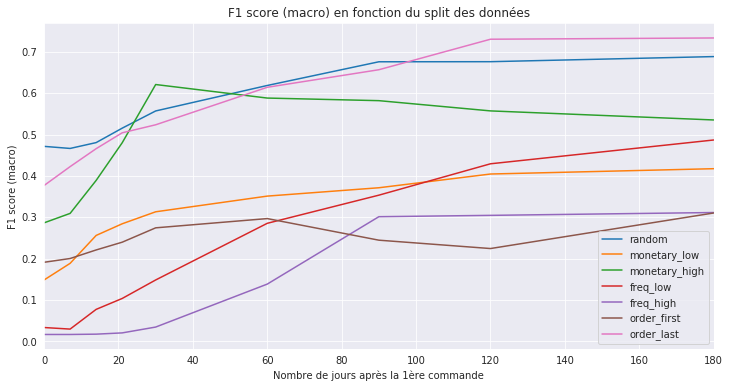

In [0]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

rank_monetary_cust = customers.MonetaryValue.rank(pct=True)
rank_freq_cust = customers.Freq.rank(pct=True)
rank_order_cust = customers.FirstOrderDate.rank(pct=True)

cust_train = {}
cust_test = {}

cust_train['random'], cust_test['random'] = train_test_split(customers.index,
                                                             test_size=0.2,
                                                             random_state=0)

cust_train['monetary_low'] = rank_monetary_cust[rank_monetary_cust < 0.8].index
cust_test['monetary_low'] = rank_monetary_cust[rank_monetary_cust >= 0.8].index
cust_train['monetary_high'] = rank_monetary_cust[rank_monetary_cust > 0.2].index
cust_test['monetary_high'] = rank_monetary_cust[rank_monetary_cust <= 0.2].index

cust_train['freq_low'] = rank_freq_cust[rank_freq_cust < 0.8].index
cust_test['freq_low'] = rank_freq_cust[rank_freq_cust >= 0.8].index
cust_train['freq_high'] = rank_freq_cust[rank_freq_cust > 0.2].index
cust_test['freq_high'] = rank_freq_cust[rank_freq_cust <= 0.2].index

cust_train['order_first'] = rank_order_cust[rank_order_cust < 0.8].index
cust_test['order_first'] = rank_order_cust[rank_order_cust >= 0.8].index
cust_train['order_last'] = rank_order_cust[rank_order_cust > 0.2].index
cust_test['order_last'] = rank_order_cust[rank_order_cust <= 0.2].index

f1_scores = {}
n_items_clusters = 9
days = [0, 7, 14, 21, 30, 60, 90, 120, 180]

for key in cust_train:
    for n_days in days:

        y_pred, y_test = pipeline(
            n_items_clusters, n_days, 
            cust_train=cust_train[key], cust_test=cust_test[key],
            classifier=LogisticRegression,
            **dict(solver='lbfgs', multi_class='auto', max_iter=10000)
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            f1_scores[(key, n_days)] = f1_score(y_pred, y_test, average='macro')

scores = pd.DataFrame(index=cust_train.keys(), columns=days, dtype='float64')
for tup, val in f1_scores.items():
    scores.loc[tup[0], tup[1]] = val

scores.T.plot(figsize=(12, 6))

plt.title("F1 score (macro) en fonction du split des données")
plt.xlabel("Nombre de jours après la 1ère commande")
plt.ylabel("F1 score (macro)")
plt.show()

Selon le nombre de jours de visibilité, les meilleurs résultats sont obtenus en utilisant les premières commandes des clients les plus anciennes pour l'entrainement et les premières commandes les plus récentes pour la validation. Cela s'explique par le fait que le jeu de validation est celui qui contient le plus d'éléments du meilleur cluster de clients. On peut les identifier par le nombre important de commandes effectuées et leur répétition.

Résultats avec split aléatoire :



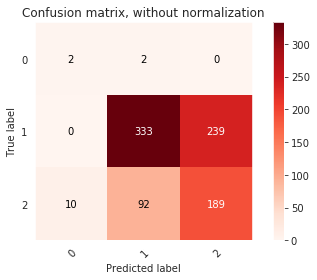

              precision    recall  f1-score   support

           0       0.17      0.50      0.25         4
           1       0.78      0.58      0.67       572
           2       0.44      0.65      0.53       291

    accuracy                           0.60       867
   macro avg       0.46      0.58      0.48       867
weighted avg       0.66      0.60      0.62       867


 Résultats avec validation sur les premières commandes : 



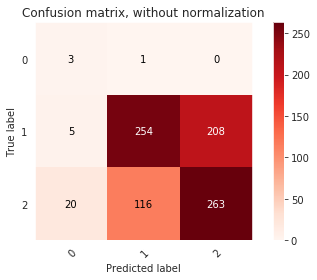

              precision    recall  f1-score   support

           0       0.11      0.75      0.19         4
           1       0.68      0.54      0.61       467
           2       0.56      0.66      0.60       399

    accuracy                           0.60       870
   macro avg       0.45      0.65      0.47       870
weighted avg       0.62      0.60      0.60       870



In [0]:
y_test_rnd, y_pred_rnd = pipeline(
    n_items_clusters=9, n_days=14, 
    cust_train=cust_train['random'], cust_test=cust_test['random'],
    classifier=LogisticRegression, 
    **{'solver': 'lbfgs', 'max_iter': 10000, 'multi_class': 'auto'}
)

y_test_last, y_pred_last = pipeline(
    n_items_clusters=9, n_days=14, 
    cust_train=cust_train['order_last'], cust_test=cust_test['order_last'],
    classifier=LogisticRegression, 
    **{'solver': 'lbfgs', 'max_iter': 10000, 'multi_class': 'auto'}
)

print(print_color.BOLD + "Résultats avec split aléatoire :" + print_color.END, 
      end="\n\n")
plot_confusion_matrix(y_test_rnd, y_pred_rnd)
plt.show()
print(classification_report(y_test_rnd, y_pred_rnd), end="\n\n")

print(print_color.BOLD, "Résultats avec validation sur les premières commandes :",
      print_color.END, end="\n\n")
plot_confusion_matrix(y_test_last, y_pred_last)
plt.show()
print(classification_report(y_test_last, y_pred_last))

Les résultats sont effectivement meilleurs du fait de la bonne prédction sur le cluster 2 et de la sur-représentation dans la distribution (8 vs. 4).

In [0]:
f1_scores = {}
n_items_clusters = 9
days = [0, 1, 3, 7, 10, 14, 21, 30, 45, 60, 90, 120, 180]

cust_train, cust_test = train_test_split(customers.index, test_size=0.2, random_state=0)

for n_day in days:

    y_pred, y_test = pipeline(
        n_items_clusters, n_days, 
        cust_train=cust_train, cust_test=cust_test,
        classifier=LogisticRegression,
        **dict(solver='lbfgs', multi_class='auto', max_iter=10000)
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        f1_scores[(key, n_days)] = f1_score(y_pred, y_test, average='macro')

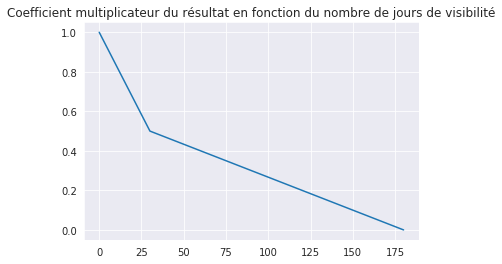

In [0]:
score_coefs = list(np.linspace(1, 0.5, num=30, endpoint=False)) + list(np.linspace(0.5, 0, num=151))
plt.plot(score_coefs)
plt.title("Coefficient multiplicateur du résultat en fonction du nombre de jours de visibilité")
plt.show()

In [0]:
f1_scores = {}
n_items_clusters = 9
days = [0, 1, 3, 7, 10, 14, 21, 30, 45, 60, 90, 120, 180]

cust_train, cust_test = train_test_split(customers.index, test_size=0.2, random_state=0)

for n_day in days:

    y_pred, y_test = pipeline(
        n_items_clusters, n_days, 
        cust_train=cust_train, cust_test=cust_test,
        classifier=LogisticRegression,
        **dict(solver='lbfgs', multi_class='auto', max_iter=10000)
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        f1_scores[(key, n_days)] = f1_score(y_pred, y_test, average='macro')

In [0]:
def create_dataset(n_days_list, n_items_clusters=9):

    items_km = KMeans(n_items_clusters, n_init=10, random_state=0)
    items_clust = items_km.fit_predict(mat)

    items_to_clust = dict(zip(items.index, items_clust))

    no_cancellation['ItemCluster'] = no_cancellation['StockCode'].map(items_to_clust)

    data = no_cancellation.groupby(['InvoiceNo', 'ItemCluster']).TotalPrice.sum()
    data = data.unstack().fillna(0)
    data['TotalPrice'] = data.sum(axis=1)

    data['InvoiceDate'] = data.index.map(invoices['InvoiceDate'])
    data['CustomerID'] = data.index.map(invoices['CustomerID'])

    data['CustFirstOrderDate'] = data['CustomerID'].map(customers['FirstOrderDate'])
    data['DaysSince1stOrder'] = (data['InvoiceDate'] - data['CustFirstOrderDate']).dt.days

    subdata = {}
    for n_days in n_days_list:
        tmp = data[data['DaysSince1stOrder'] <= n_days]
        tmp = tmp.drop(columns=['InvoiceDate', 'CustFirstOrderDate', 'DaysSince1stOrder'])
        tmp['N_orders'] = tmp.index.map(invoices['N_orders'])

        tmp = tmp.groupby('CustomerID').sum()

        
        tmp[list(range(n_items_clusters))] = tmp[list(range(n_items_clusters))].div(tmp['TotalPrice'].values, axis=0)

        subdata[n_days] = tmp.reset_index(drop=False)
        subdata[n_days]['N_days'] = n_days

    return pd.concat((subdata[n_days] for n_days in n_days_list), ignore_index=True)

def split_dataset(dataset, cust_train, cust_test):
    dtrain = dataset[dataset['CustomerID'].isin(cust_train)]
    dtest = dataset[dataset['CustomerID'].isin(cust_test)]
    return dtrain, dtest

In [0]:
model_data = create_dataset(n_days_list=[0, 1, 3, 7, 10, 14, 21, 30, 45, 60, 90, 120, 180],
                            n_items_clusters=9)
model_data

ItemCluster,CustomerID,0,1,2,3,4,5,6,7,8,TotalPrice,N_orders,N_days
0,12347,0.738125,0.000000,0.000000,0.118012,0.000000,0.0,0.063221,0.080642,0.000000,711.79,1.0,0
1,12348,0.850806,0.000000,0.000000,0.077957,0.071237,0.0,0.000000,0.000000,0.000000,892.80,1.0,0
2,12349,0.802287,0.011323,0.017183,0.087992,0.005804,0.0,0.017667,0.057745,0.000000,1757.55,1.0,0
3,12350,0.759569,0.000000,0.061005,0.000000,0.000000,0.0,0.120215,0.059211,0.000000,334.40,1.0,0
4,12352,0.934233,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065767,0.000000,296.50,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56337,18280,0.917774,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.082226,0.000000,180.60,1.0,180
56338,18281,0.795843,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.204157,0.000000,80.82,1.0,180
56339,18282,0.872283,0.000000,0.000000,0.000000,0.028307,0.0,0.000000,0.099410,0.000000,178.05,2.0,180
56340,18283,0.456823,0.000000,0.339410,0.061893,0.000000,0.0,0.072290,0.069584,0.000000,842.58,7.0,180


In [0]:
cust_train, cust_test = train_test_split(customers.index, test_size=0.2, random_state=0)
dtrain, dtest = split_dataset(model_data, cust_train, cust_test)

scaler = StandardScaler().fit(dtrain[['TotalPrice', 'N_orders']])
dtrain[['TotalPrice', 'N_orders']] = scaler.transform(dtrain[['TotalPrice', 'N_orders']])
dtest[['TotalPrice', 'N_orders']] = scaler.transform(dtest[['TotalPrice', 'N_orders']])

min_max = MinMaxScaler().fit(dtrain[['N_days']])
dtrain[['N_days']] = min_max.transform(dtrain[['N_days']])
dtest[['N_days']] = min_max.transform(dtest[['N_days']])

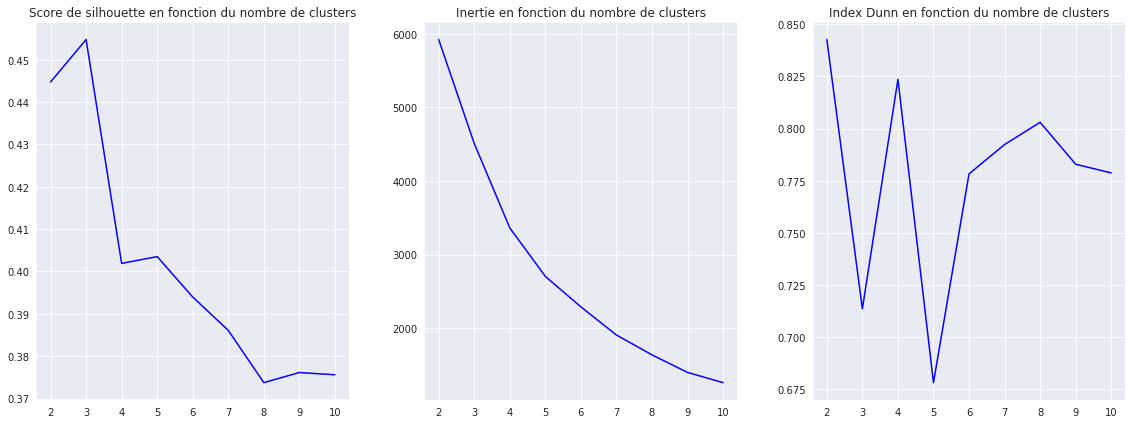

In [0]:
train_data = customers.loc[customers.index.isin(cust_train), ['Recency', 'Freq', 'MonetaryValue']]
    
clust_scaler = PowerTransformer()
scaled_train_data = clust_scaler.fit_transform(train_data)

n_clusters = list(range(2, 11))

kmean = {}
silhouette = {}
inertia = {}
dunn_index = {}

for k in n_clusters:
    km = KMeans(k, n_init=10, random_state=0)
    labels = km.fit_predict(scaled_train_data)
    kmean[k] = km
    silhouette[k] = silhouette_score(scaled_train_data, labels)
    inertia[k] = km.inertia_
    dunn_index[k] = davies_bouldin_score(scaled_train_data, labels)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

ax[0].plot(n_clusters, [silhouette[k] for k in n_clusters], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(n_clusters, [inertia[k] for k in n_clusters], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

ax[2].plot(n_clusters, [dunn_index[k] for k in n_clusters], 'b-')
ax[2].set_title("Index Dunn en fonction du nombre de clusters")

plt.tight_layout()
plt.show()

In [0]:
km_cust = KMeans(4, n_init=50, random_state=0)
train_labels = km_cust.fit_predict(scaled_train_data)

train_data['Cluster'] = train_labels
cust_to_clust = dict(train_data['Cluster'])

centroids = pd.DataFrame(clust_scaler.inverse_transform(km_cust.cluster_centers_), 
                         columns=['Recency', 'Freq', 'MonetaryValue'])
centroids['ClusterSize'] = pd.Series(train_labels).value_counts()
centroids

,Recency,Freq,MonetaryValue,ClusterSize
0,-10.842209,0.267771,2467.186558,938
1,-209.434429,0.040416,370.238683,1051
2,-5.191251,0.517665,91992.244679,14
3,-42.168142,0.102751,1042.956440,1464


In [0]:
train_data['Cluster'] = train_labels
y_train = dtrain['CustomerID'].map(train_data['Cluster'])

test_data = customers.loc[customers.index.isin(cust_test), ['Recency', 'Freq', 'MonetaryValue']]
scaled_test = clust_scaler.transform(test_data)
test_labels = km_cust.predict(scaled_test)
test_data['Cluster'] = test_labels
y_test = dtest['CustomerID'].map(test_data['Cluster'])

In [0]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
clf.fit(dtrain.drop(columns='CustomerID'), y_train)
y_pred = clf.predict(dtest.drop(columns='CustomerID'))
f1_score(y_pred, y_test, average='macro')

0.42646978995777457

In [0]:
clf = SVC(C=1, kernel='rbf', gamma='scale', tol=0.01, random_state=0)
clf.fit(dtrain.drop(columns='CustomerID'), y_train)
y_pred = clf.predict(dtest.drop(columns='CustomerID'))
f1_score(y_pred, y_test, average='macro')

0.4258349173221171

In [0]:
def get_coef(n_items_clusters=5, n_days=0, 
             cust_train=None, cust_test=None, 
             classifier=LogisticRegression, **clf_kw):
    

    items_km = KMeans(n_items_clusters, n_init=10, random_state=0)
    items_clust = items_km.fit_predict(mat)

    items_to_clust = dict(zip(items.index, items_clust))

    no_cancellation['ItemCluster'] = no_cancellation['StockCode'].map(items_to_clust)

    data = no_cancellation.groupby(['InvoiceNo', 'ItemCluster']).TotalPrice.sum()
    data = data.unstack().fillna(0)
    data['TotalPrice'] = data.sum(axis=1)

    data['InvoiceDate'] = data.index.map(invoices['InvoiceDate']).date
    data['CustomerID'] = data.index.map(invoices['CustomerID'])

    data['CustFirstOrderDate'] = data['CustomerID'].map(customers['FirstOrderDate']).dt.date
    data['DaysSince1stOrder'] = (data['InvoiceDate'] - data['CustFirstOrderDate']).dt.days

    data = data[data['DaysSince1stOrder'] <= n_days]
    data = data.drop(columns=['InvoiceDate', 'CustFirstOrderDate', 'DaysSince1stOrder'])
    data['N_orders'] = 1

    data = data.groupby('CustomerID').sum()

    data[list(range(n_items_clusters))] = data[list(range(n_items_clusters))].div(data['TotalPrice'].values, axis=0)

    dtrain = data[data.index.isin(cust_train)]
    dtest = data[data.index.isin(cust_test)]

    y_train = dtrain.index.map(cust_to_clust)
    y_test = dtest.index.map(cust_to_clust)

    scaler = StandardScaler().fit(dtrain[['TotalPrice', 'N_orders']])
    dtrain[['TotalPrice', 'N_orders']] = scaler.transform(dtrain[['TotalPrice', 'N_orders']])
    dtest[['TotalPrice', 'N_orders']] = scaler.transform(dtest[['TotalPrice', 'N_orders']])

    clf = classifier(**clf_kw)
    clf.fit(dtrain, y_train)
    y_pred = clf.predict(dtest)

    return clf.coef_

In [0]:
get_coef(
    n_items_clusters=9, n_days=14, 
    cust_train=cust_train['random'], cust_test=cust_test['random'],
    classifier=LogisticRegression, 
    **{'solver': 'lbfgs', 'max_iter': 10000, 'multi_class': 'auto'}
)

array([[ 0.02809599,  0.4040454 , -0.23931573, -0.50758588,  1.02471099,
         0.07695924, -0.42581719, -0.4620214 ,  0.11125799, -0.062213  ,
         0.02949384],
       [ 0.39763248, -0.3354101 ,  0.12611172, -0.15549282, -0.60173419,
        -0.07457242,  0.24021913,  0.41757521, -0.00452512, -0.32720635,
        -0.50143879],
       [-0.42572848, -0.0686353 ,  0.11320401,  0.66307871, -0.4229768 ,
        -0.00238682,  0.18559806,  0.04444619, -0.10673287,  0.38941934,
         0.47194495]])

In [0]:
param_grid = dict(
    solver = ('lbfgs', 'liblinear'),
    class_weight = (None, 'balanced'),
    penalty = ('none', 'elasticnet'),
    multi_class = ('ovr', 'multinomial', 'auto'),
    C = (0.01, 0.1, 1, 10),
    l1_ratio = (0, 0.1, 0.25, 0.5, 0.9, 1),
)



grid_search = GridSearchCV(LogisticRegression(max_iter=10000),
                           param_grid=trim_logreg_param_grid(param_grid), 
                           scoring='f1_macro', 
                           error_score=np.NaN,
                           cv=5)

grid_search.fit(cust_train['ra'], y_train.values.ravel())

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
GridSe

In [0]:
cvect = CountVectorizer()
mat = cvect.fit_transform(clean_text(items['Description']))
mat.shape

(3823, 1926)

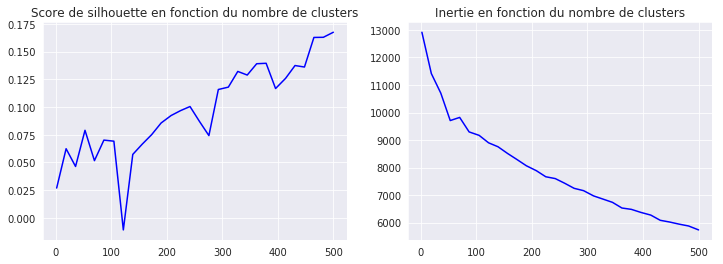

In [0]:
n_clusters = np.linspace(2, 500, 30, dtype=int)

kmean = {}
silhouette = {}
inertia = {}

for k in n_clusters:
    km = KMeans(k, n_init=10, random_state=0)
    labels = km.fit_predict(mat)
    kmean[k] = km
    silhouette[k] = silhouette_score(mat, labels)
    inertia[k] = km.inertia_
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(n_clusters, [silhouette[k] for k in n_clusters], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(n_clusters, [inertia[k] for k in n_clusters], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

plt.show()

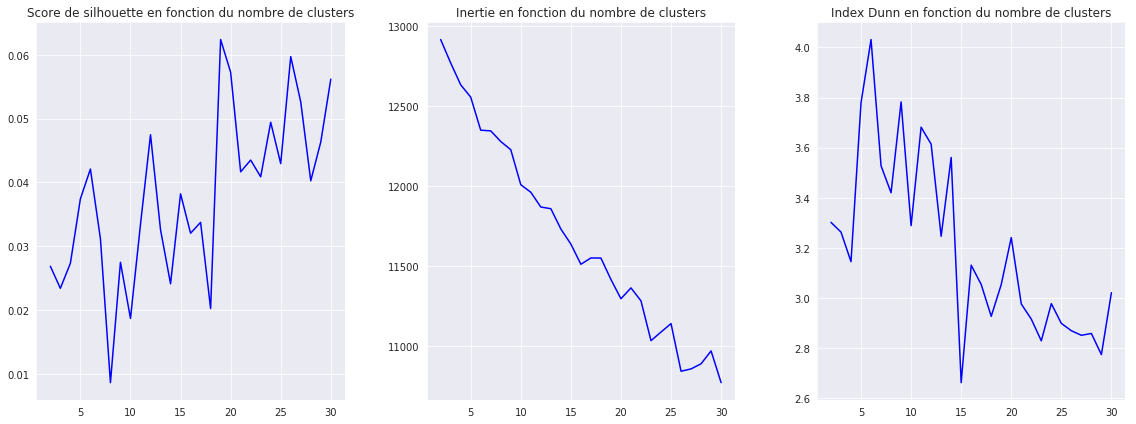

In [0]:
n_clusters = list(range(2, 31))

dense_mat = mat.toarray()

kmean = {}
silhouette = {}
inertia = {}
dunn_index = {}

for k in n_clusters:
    km = KMeans(k, n_init=10, random_state=0)
    labels = km.fit_predict(mat)
    kmean[k] = km
    silhouette[k] = silhouette_score(mat, labels)
    inertia[k] = km.inertia_
    dunn_index[k] = davies_bouldin_score(dense_mat, labels)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

ax[0].plot(n_clusters, [silhouette[k] for k in n_clusters], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(n_clusters, [inertia[k] for k in n_clusters], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

ax[2].plot(n_clusters, [dunn_index[k] for k in n_clusters], 'b-')
ax[2].set_title("Index Dunn en fonction du nombre de clusters")

plt.tight_layout()
plt.show()

In [0]:
colors = pd.read_html('https://simple.wikipedia.org/wiki/List_of_colors')
color_names = colors[0]['Name']
colors_list = []
for color in color_names:
    print(f"'{color.lower()}',") 

'amaranth',
'amber',
'amethyst',
'apricot',
'aquamarine',
'azure',
'baby blue',
'beige',
'black',
'blue',
'blue-green',
'blue-violet',
'blush',
'bronze',
'brown',
'burgundy',
'byzantium',
'carmine',
'cerise',
'cerulean',
'champagne',
'chartreuse green',
'chocolate',
'cobalt blue',
'coffee',
'copper',
'coral',
'crimson',
'cyan',
'desert sand',
'electric blue',
'emerald',
'erin',
'gold',
'gray',
'green',
'harlequin',
'indigo',
'ivory',
'jade',
'jungle green',
'lavender',
'lemon',
'lilac',
'lime',
'magenta',
'magenta rose',
'maroon',
'mauve',
'navy blue',
'ochre',
'olive',
'orange',
'orange-red',
'orchid',
'peach',
'pear',
'periwinkle',
'persian blue',
'pink',
'plum',
'prussian blue',
'puce',
'purple',
'raspberry',
'red',
'red-violet',
'rose',
'ruby',
'salmon',
'sangria',
'sapphire',
'scarlet',
'silver',
'slate gray',
'spring bud',
'spring green',
'tan',
'taupe',
'teal',
'turquoise',
'ultramarine',
'violet',
'viridian',
'white',
'yellow',


In [0]:
pandas_profiling.ProfileReport(items).to_file("Items_EDA.html")

In [0]:
files.download("Items_EDA.html")

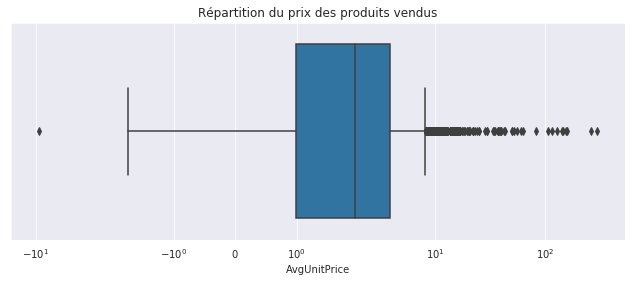

In [0]:
fig, ax = plt.subplots(figsize=(11, 4))
ax.set_xscale("symlog")
sns.boxplot('AvgUnitPrice', data=items)
plt.title("Répartition du prix des produits vendus")
plt.show()

In [0]:
customers.Country.value_counts()

United Kingdom          3950
Germany                   95
France                    87
Spain                     30
Belgium                   24
Switzerland               20
Portugal                  19
Italy                     15
Finland                   12
Norway                    10
Austria                    9
Netherlands                9
Channel Islands            9
Australia                  9
Japan                      8
Sweden                     8
Denmark                    8
Cyprus                     6
Poland                     6
Greece                     4
Israel                     4
Canada                     4
Unspecified                4
USA                        4
EIRE                       3
Bahrain                    2
United Arab Emirates       2
Malta                      2
Singapore                  1
Lithuania                  1
Iceland                    1
Czech Republic             1
Brazil                     1
European Community         1
Saudi Arabia  

In [0]:
customers_clust = customers[['CountryGroup', 'LastOrder', 'Freq', 'MonetaryValue']]
    
customers_clust['UK'] = (customers_clust['CountryGroup'] == 'UK').astype('uint8')
customers_clust['Europe'] = (customers_clust['CountryGroup'] == 'Europe').astype('uint8')
customers_clust = customers_clust.drop('CountryGroup', axis=1)

clust_scaler = PowerTransformer()
scaled_customers = clust_scaler.fit_transform(customers_clust[['LastOrder', 'Freq', 'MonetaryValue']])
scaled_customers = np.hstack((scaled_customers, customers_clust[['UK', 'Europe']]))

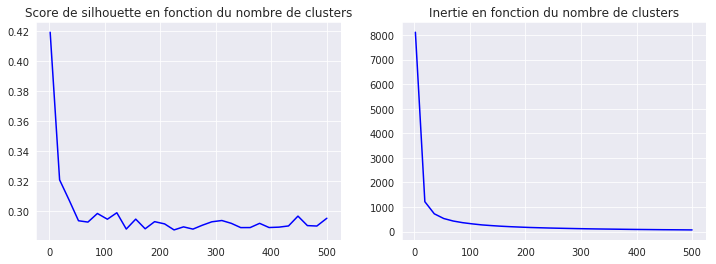

In [0]:
n_clusters = np.linspace(2, 500, 30, dtype=int)

kmean = {}
silhouette = {}
inertia = {}

for k in n_clusters:
    km = KMeans(k, n_init=10, random_state=0)
    labels = km.fit_predict(scaled_customers)
    kmean[k] = km
    silhouette[k] = silhouette_score(scaled_customers, labels)
    inertia[k] = km.inertia_
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(n_clusters, [silhouette[k] for k in n_clusters], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(n_clusters, [inertia[k] for k in n_clusters], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

plt.show()

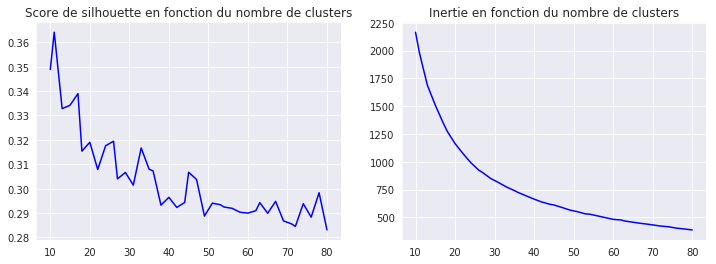

In [0]:
n_clusters = np.linspace(10, 80, 40, dtype=int)

kmean = {}
silhouette = {}
inertia = {}

for k in n_clusters:
    km = KMeans(k, n_init=10, random_state=0)
    labels = km.fit_predict(scaled_customers)
    kmean[k] = km
    silhouette[k] = silhouette_score(scaled_customers, labels)
    inertia[k] = km.inertia_
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(n_clusters, [silhouette[k] for k in n_clusters], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(n_clusters, [inertia[k] for k in n_clusters], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

plt.show()

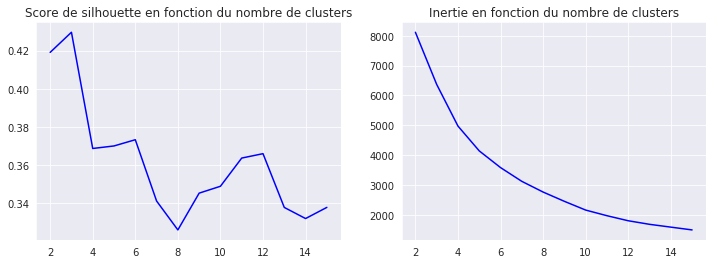

In [0]:
K = range(2, 16)
for k in K:
    km = KMeans(k, n_init=50, random_state=0)
    labels = km.fit_predict(scaled_customers)
    kmean[k] = km
    silhouette[k] = silhouette_score(scaled_customers, labels)
    inertia[k] = km.inertia_

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K, [silhouette[k] for k in K], 'b-')
ax[0].set_title("Score de silhouette en fonction du nombre de clusters")

ax[1].plot(K, [inertia[k] for k in K], 'b-')
ax[1].set_title("Inertie en fonction du nombre de clusters")

plt.show()

###Classification finale des clients

In [0]:
customers_clust = customers[['Recency', 'Freq', 'MonetaryValue']]
    
clust_scaler = PowerTransformer()
scaled_customers = clust_scaler.fit_transform(customers_clust)

km = KMeans(3, n_init=50, random_state=0)
labels = km.fit_predict(scaled_customers)

customers_clust['Cluster'] = labels
cust_to_clust = dict(customers_clust['Cluster'])

centroids = pd.DataFrame(clust_scaler.inverse_transform(km.cluster_centers_), 
                         columns=['Recency', 'Freq', 'MonetaryValue'])
centroids['ClusterSize'] = pd.Series(labels).value_counts()
centroids

,Recency,Freq,MonetaryValue,ClusterSize
0,-5.650270,0.457474,61348.936286,34
1,-138.634602,0.054604,525.971514,2121
2,-17.510511,0.181729,1747.921394,2179


In [0]:
customers_1st_order = df.sort_values('InvoiceDate', ascending=True)

crit1 = ~customers_1st_order.CustomerID.isna()
crit2 = customers_1st_order.TotalPrice > 0

customers_1st_order = customers_1st_order[crit1 & crit2]

customers_1st_order = customers_1st_order.drop_duplicates('CustomerID')
customers_1st_order = customers_1st_order.set_index('CustomerID').sort_index()

customers_1st_order = customers_1st_order[['InvoiceNo']]
customers_1st_order = customers_1st_order.merge(
    invoices, left_on='InvoiceNo', right_index=True
)
customers_1st_order['Items'] = customers_1st_order['Items'].apply(', '.join)

customers_1st_order['Cluster'] = customers_1st_order.index.map(cust_to_clust)

customers_1st_order.head()

,InvoiceNo,InvoiceDate,Recency,CustomerID,Country,CountryGroup,Items,NumberOfLines,TotalQty,TotalPrice,Cluster
CustomerID,,,,,,,,,,,
12347,537626,2010-12-07 14:57:00,366,12347,Iceland,Europe,"85116, 22375, 71477, 22492, 22771, 22772, 2277...",31,319,711.79,1
12348,539318,2010-12-16 19:09:00,357,12348,Finland,Europe,"84992, 22951, 84991, 21213, 22616, 21981, 2198...",13,1254,892.80,0
12349,577609,2011-11-21 09:51:00,18,12349,Italy,Europe,"23112, 23460, 21564, 21411, 21563, 22131, 2219...",73,631,1757.55,1
12350,543037,2011-02-02 16:01:00,309,12350,Norway,Europe,"21908, 22412, 79066K, 79191C, 22348, 84086C, 2...",17,197,334.40,0
12352,544156,2011-02-16 12:33:00,296,12352,Norway,Europe,"21380, 22064, 21232, 22646, 22779, 22423, 2265...",15,98,296.50,1


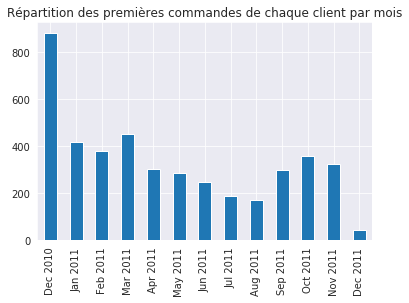

In [0]:
data = customers_1st_order.resample("1m", on='InvoiceDate').InvoiceDate.count()
data.index = data.index.strftime('%b %Y')
data.plot.bar()
plt.title("Répartition des premières commandes de chaque client par mois")
plt.show()

Il a 2 fois plus de première commande dans le premier mois du dataset. La raison est simple : le dataset est coupé dans le temps, il est certain que la moitié de ces commandes provient de clients qui avaient déjà passé des commandes avant le mois de décembre 2010. Il faudra peut-être retirer une partie de ces commandes car biaisée.

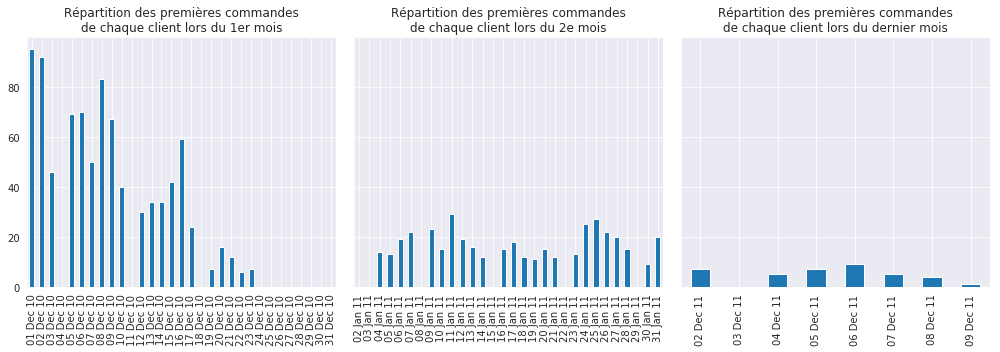

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

data = customers_1st_order.resample("1d", on='InvoiceDate').InvoiceNo.count()
data = data[data.index < '2011-01-01']
data.index = data.index.strftime('%d %b %y')
data.plot.bar(ax=ax[0])
ax[0].set_title("Répartition des premières commandes\nde chaque client lors du 1er mois")

data = customers_1st_order.resample("1d", on='InvoiceDate').InvoiceNo.count()
data = data[(data.index > '2011-01-01') & (data.index < '2011-02-01')]
data.index = data.index.strftime('%d %b %y')
data.plot.bar(ax=ax[1])
ax[1].set_title("Répartition des premières commandes\nde chaque client lors du 2e mois")

data = customers_1st_order.resample("1d", on='InvoiceDate').InvoiceNo.count()
data = data[data.index > '2011-12-01']
data.index = data.index.strftime('%d %b %y')
data.plot.bar(ax=ax[2])
ax[2].set_title("Répartition des premières commandes\nde chaque client lors du dernier mois")

plt.tight_layout()
plt.show()

A mois comparable (décembre), il y a eu très peu de nouveaux clients sur les 9 premiers jours. Soit le business est en dégradation, ce que les chiffres de vente ne semblent pas indiquer, soit les "nouveaux clients" des premiers mois sont en majoritairement des clients déjà connus qui commandent simplement pour la première fois depuis le 1er décembre 2010.

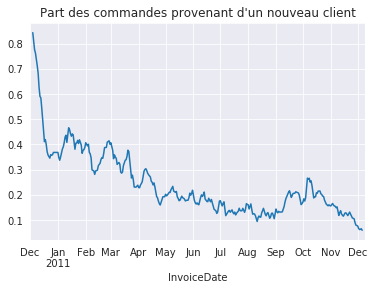

In [0]:
num = customers_1st_order.resample("1d", on='InvoiceDate').size()
denom = invoices[~invoices.CustomerID.isna()].resample("1d", on='InvoiceDate').size()

first_order_rate = num / denom

first_order_rate = first_order_rate.fillna(method='backfill')

first_order_rate.rolling(7, center=True).mean().plot()
plt.title("Part des commandes provenant d'un nouveau client")
plt.show()

In [0]:
invoices[invoices.index.str.startswith('C')]

,InvoiceDate,Recency,CustomerID,Country,CountryGroup,Items,NumberOfLines,TotalQty,TotalPrice
InvoiceNo,,,,,,,,,
C536379,2010-12-01 09:41:00,373,14527,United Kingdom,UK,[D],1,-1,-27.50
C536391,2010-12-01 10:24:00,373,17548,United Kingdom,UK,"[22556, 21984, 21983, 21980, 21484, 22557, 22553]",7,-132,-141.48
C536543,2010-12-01 14:41:00,372,17841,United Kingdom,UK,"[22632, 22355, 21495, 46000R, 46000S, 22731, 2...",64,196,533.58
C536548,2010-12-01 14:33:00,372,12472,Germany,Europe,"[22244, 22242, 20914, 22892, 22654, 22767, 223...",14,-40,-122.30
C536606,2010-12-02 09:10:00,372,14092,United Kingdom,UK,[20914],1,-2,-5.90
C536622,2010-12-02 10:37:00,372,12471,Germany,Europe,[22752],1,-2,-17.00
C536625,2010-12-02 10:46:00,372,14766,United Kingdom,UK,[22839],1,-2,-29.90
C536642,2010-12-02 11:57:00,372,14390,United Kingdom,UK,"[21463, 85136A, 85099B, 22385, 21870, 20723, 2...",27,73,217.75
C536734,2010-12-02 12:50:00,372,16042,United Kingdom,UK,"[22780, 85048]",2,-5,-24.95


In [0]:
crit1 = invoices.index.str.startswith('C')
crit2 = invoices.TotalPrice < -1
invoices[~crit1 & crit2]

,InvoiceDate,Recency,CustomerID,Country,CountryGroup,Items,NumberOfLines,TotalQty,TotalPrice
InvoiceNo,,,,,,,,,
536663,2010-12-02 16:58:00,371,16546,United Kingdom,UK,"[22867, 22633, 22632, 22910, 22737, 22952, 225...",12,-696,-583.68
538721,2010-12-14 11:11:00,360,17526,United Kingdom,UK,"[22224, 71053]",2,0,-3.20
540939,2011-01-12 12:10:00,331,15061,United Kingdom,UK,"[22467, 22543, 85178]",3,-46,-38.34
541782,2011-01-21 11:50:00,322,13102,United Kingdom,UK,"[22355, 21481, 22663, 22659]",4,-14,-40.30
545306,2011-03-01 13:05:00,282,17027,United Kingdom,UK,"[22914, 22079, 22414, 20793]",4,0,-28.50
546161,2011-03-10 09:53:00,274,17404,Sweden,Europe,"[22651, 85178]",2,0,-57.60
547165,2011-03-21 12:10:00,263,13593,United Kingdom,UK,"[84755, 84750A]",2,0,-31.20
550824,2011-04-21 10:00:00,232,18177,United Kingdom,UK,"[21934, 20934]",2,0,-19.00
551138,2011-04-26 13:12:00,226,17061,United Kingdom,UK,"[22719, 21352, 22467, 23152]",4,0,-55.44


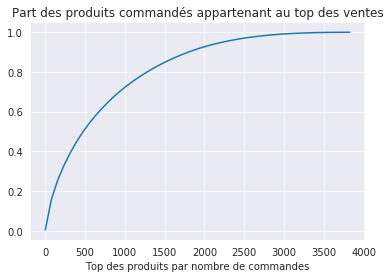

In [0]:
items_as_set = invoices.Items.apply(set)
N_items = items_as_set.apply(len).sum()
pct_items = {}

for k in np.linspace(1, items.shape[0], 50, dtype=int):
    top_items = set(items.nlargest(k, 'NumberOfOrders').index)
    pct_items[k] = items_as_set.apply(lambda x: len(x & top_items)).sum() / N_items
    
plt.plot(pct_items.keys(), pct_items.values())
plt.title("Part des produits commandés appartenant au top des ventes")
plt.xlabel("Top des produits par nombre de commandes")
plt.show()

In [0]:
dtrain, dtest, train_index, test_index  = train_test_split(
    customers_1st_order, np.arange(customers_1st_order.shape[0]),
    test_size=0.2, random_state=0
)

train_cust, test_cust = dtrain.index, dtest.index

In [0]:
num_encoder = StandardScaler()
invoice0_train = num_encoder.fit_transform(dtrain[['NumberOfLines', 'TotalPrice']])
invoice0_test = num_encoder.transform(dtest[['NumberOfLines', 'TotalPrice']])

item_encoder = CountVectorizer(lowercase=False, max_features=1000)
item_matrix = item_encoder.fit_transform(customers_1st_order['Items'])
items_train = filter_rows_csr(item_matrix, train_index)
items_test = filter_rows_csr(item_matrix, test_index)

items_list = sorted(item_encoder.vocabulary_, key=item_encoder.vocabulary_.get)

In [0]:
invoice_total_qty = df.groupby('InvoiceNo').Quantity.sum()

qty_matrix = df.groupby(['InvoiceNo', 'StockCode']).Quantity.sum().unstack().fillna(0)
qty_matrix = qty_matrix[items_list].loc[customers_1st_order.InvoiceNo]
qty_matrix['other'] = invoice_total_qty.loc[customers_1st_order.InvoiceNo] - qty_matrix.sum(axis=1)
qty_matrix.head()

StockCode,10133,10135,15036,15056BL,15056N,15056P,16156S,16161P,16161U,16169E,16237,17003,20668,20674,20675,20676,20677,20679,20682,20685,20711,20712,20713,20717,20718,20719,20723,20724,20725,20726,20727,20728,20749,20750,20751,20752,20754,20828,20829,20914,...,84978,84987,84988,84991,84992,84997A,84997B,84997C,84997D,85014A,85014B,85015,85034C,85038,85040A,85048,85049A,85049C,85049D,85049E,85049G,85053,85061W,85062,85066,85099B,85099C,85099F,85123A,85150,85152,85174,85175,85178,85184C,85199S,85206A,85227,POST,other
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
537626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0
539318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,48.0,144.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,120.0
577609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,127.0
543037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100.0
544156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [0]:
invoice_total_price = df.groupby('InvoiceNo').TotalPrice.sum()

price_matrix = df.groupby(['InvoiceNo', 'StockCode']).TotalPrice.sum().unstack().fillna(0)
price_matrix = price_matrix[items_list].loc[customers_1st_order.InvoiceNo]
price_matrix['other'] = invoice_total_price.loc[customers_1st_order.InvoiceNo] - price_matrix.sum(axis=1)

In [0]:
qty_matrix = scipy.sparse.csr_matrix(qty_matrix)
qty_train = filter_rows_csr(qty_matrix, train_index)
qty_test = filter_rows_csr(qty_matrix, test_index)

price_matrix = scipy.sparse.csr_matrix(price_matrix)
price_train = filter_rows_csr(price_matrix, train_index)
price_test = filter_rows_csr(price_matrix, test_index)

In [0]:
y_train = dtrain[['Cluster']]
y_test = dtest[['Cluster']]

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       427
           1       0.51      0.51      0.51       428
           2       0.50      0.17      0.25        12

    accuracy                           0.51       867
   macro avg       0.51      0.40      0.42       867
weighted avg       0.51      0.51      0.51       867



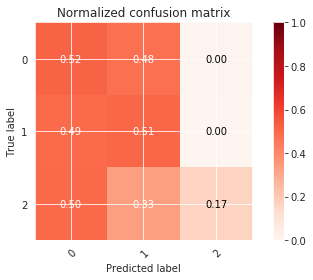

In [0]:
invoice_train = scipy.sparse.hstack((invoice0_train, items_train)).tocsr()
invoice_test = scipy.sparse.hstack((invoice0_test, items_test)).tocsr()

lr = LogisticRegression(solver='lbfgs', max_iter=10000, multi_class='auto')
lr.fit(invoice_train, y_train.values.ravel())
y_pred = lr.predict(invoice_test)

plot_confusion_matrix(y_test, y_pred, normalize=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.52      0.52       427
           1       0.53      0.55      0.54       428
           2       0.18      0.17      0.17        12

    accuracy                           0.53       867
   macro avg       0.41      0.41      0.41       867
weighted avg       0.53      0.53      0.53       867



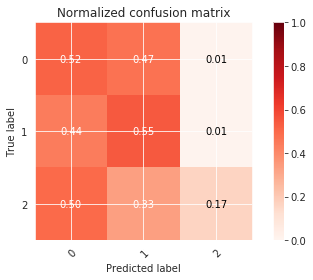

In [0]:
invoice_train = scipy.sparse.hstack((invoice0_train, price_train)).tocsr()
invoice_test = scipy.sparse.hstack((invoice0_test, price_test)).tocsr()

lr = LogisticRegression(solver='lbfgs', max_iter=10000, multi_class='auto')
lr.fit(invoice_train, y_train.values.ravel())
y_pred = lr.predict(invoice_test)

plot_confusion_matrix(y_test, y_pred, normalize=True)
print(classification_report(y_test, y_pred))

In [0]:
price_encoder = StandardScaler(with_mean=False)
price_scaled_train = price_encoder.fit_transform(price_train)
price_scaled_test = price_encoder.transform(price_test)

invoice_train = scipy.sparse.hstack((invoice0_train, price_scaled_train)).tocsr()
invoice_test = scipy.sparse.hstack((invoice0_test, price_scaled_test)).tocsr()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           0       0.53      0.52      0.53       427
           1       0.53      0.55      0.54       428
           2       0.00      0.00      0.00        12

    accuracy                           0.53       867
   macro avg       0.35      0.36      0.36       867
weighted avg       0.52      0.53      0.53       867



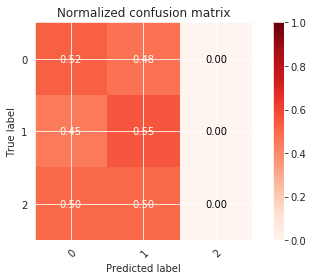

In [0]:
from sklearn.svm import SVC
svc = SVC(gamma='scale', kernel='sigmoid', max_iter=100000, decision_function_shape='ovr')
svc.fit(invoice_train, y_train.values.ravel())
y_pred = svc.predict(invoice_test)

plot_confusion_matrix(y_test, y_pred, normalize=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.52      0.52       427
           1       0.53      0.55      0.54       428
           2       0.20      0.17      0.18        12

    accuracy                           0.53       867
   macro avg       0.42      0.41      0.41       867
weighted avg       0.53      0.53      0.53       867



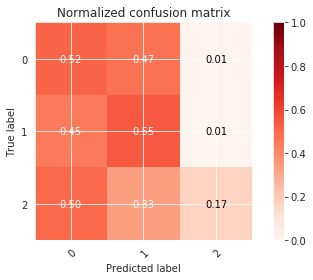

In [0]:
lr = LogisticRegression(solver='lbfgs', max_iter=100000, multi_class='auto')
lr.fit(invoice_train, y_train.values.ravel())
y_pred = lr.predict(invoice_test)

plot_confusion_matrix(y_test, y_pred, normalize=True)
print(classification_report(y_test, y_pred))

In [0]:
invoice_train = scipy.sparse.hstack((invoice0_train, price_train)).tocsr()
invoice_test = scipy.sparse.hstack((invoice0_test, price_test)).tocsr()

In [0]:
LogisticRegression(solver='lbfgs', max_iter=100000, multi_class='auto')

In [0]:
from sklearn.model_selection import GridSearch

ImportError: ignored

In [0]:
LogisticRegression()

In [0]:
from sklearn.linear_model import LogisticRegressionCV

In [0]:
lr_cv = LogisticRegressionCV(**{'Cs': (0.01, 0.1, 1, 10), 'l1_ratios': (0, 0.1, 0.25, 0.5, 0.9, 1)})
lr_cv.fit(invoice_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1992: UserWarning:

l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/usr/local/lib/python3.6

LogisticRegressionCV(Cs=(0.01, 0.1, 1, 10), class_weight=None, cv='warn',
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=(0, 0.1, 0.25, 0.5, 0.9, 1), max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
lr_cv.

In [0]:
param_grid = dict(
    solver = ('lbfgs', 'liblinear'),
    class_weight = (None, 'balanced'),
    penalty = ('none', 'elasticnet'),
    multi_class = ('ovr', 'multinomial', 'auto'),
    C = (0.01, 0.1, 1, 10),
    l1_ratio = (0, 0.1, 0.25, 0.5, 0.9, 1),
)

grid_search = GridSearchCV(LogisticRegression(max_iter=10000),
                           param_grid=trim_logreg_param_grid(param_grid), 
                           scoring='f1_macro', 
                           error_score=np.NaN,
                           cv=5)

grid_search.fit(invoice_train, y_train.values.ravel())

NameError: ignored

In [0]:
def trim_logreg_param_grid(param_grid):
    """For the LogisticRegression:
    - Remove duplicate set of parameters because some may be inactive.
    - Remove invalid combination of parameters.
    """

    params_list = []
    grid = ParameterGrid(param_grid)

    for d in grid:
        return_dict = d.copy()

        if return_dict['penalty'] == 'none':
            del return_dict['C']
            del return_dict['l1_ratio']
        elif return_dict['penalty'] == 'elasticnet' and return_dict['l1_ratio'] == 0:
            return_dict['penalty'] == 'l2'
            del return_dict['l1_ratio']
        elif return_dict['penalty'] == 'elasticnet' and return_dict['l1_ratio'] == 1:
            return_dict['penalty'] == 'l1'
            del return_dict['l1_ratio']

        if return_dict['penalty'] == 'none' and  return_dict['solver'] == 'liblinear':
            continue
        if return_dict['solver'] == 'lbfgs' and return_dict['penalty'] not in ('l2', 'none'):
            continue
        if return_dict['penalty'] == 'elasticnet' and return_dict['solver'] != 'saga':
            continue
        
        params_list.append(return_dict)

    # remove the duplicate set of parameters
    grid_no_duplicates = set(tuple(d.items()) for d in params_list)
    # force a list for keys as expected for ParameterGrid
    new_grid = [{k: to_list(v) for k, v in t} for t in grid_no_duplicates]

    return ParameterGrid(new_grid)

In [0]:
param_grid = dict(
    solver = ('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'),
    class_weight = (None, 'balanced'),
    penalty = ('none', 'elasticnet'),
    multi_class = ('ovr', 'multinomial', 'auto'),
    C = (0.01, 0.1, 1, 10),
    l1_ratio = (0, 0.1, 0.25, 0.5, 0.9, 1),
)

print(len(ParameterGrid(param_grid)))
print(len(trim_logreg_param_grid(param_grid)))

1440
144


In [0]:
for params in trim_logreg_param_grid(param_grid):
    print(params)

{'class_weight': None, 'multi_class': 'ovr', 'penalty': 'none', 'solver': 'saga'}
{'C': 1, 'class_weight': None, 'l1_ratio': 0.1, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
{'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga'}
{'C': 10, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
{'C': 10, 'class_weight': None, 'l1_ratio': 0.9, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}
{'C': 0.1, 'class_weight': None, 'l1_ratio': 0.25, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
{'class_weight': None, 'multi_class': 'ovr', 'penalty': 'none', 'solver': 'newton-cg'}
{'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'sag'}
{'C': 0.1, 'class_weight': None, 'l1_ratio': 0.5, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0.1, 'multi_class': '

In [0]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

param_grid = dict(
    solver = ('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'),
    class_weight = (None, 'balanced'),
    penalty = ('none', 'elasticnet'),
    multi_class = ('ovr', 'multinomial', 'auto'),
    C = (0.01, 0.1, 1, 10),
    l1_ratio = (0, 0.1, 0.25, 0.5, 0.9, 1),
)

grid_search = GridSearchCV(LogisticRegression(max_iter=10000),
                           param_grid=trim_logreg_param_grid(param_grid), 
                           scoring='f1_macro', 
                           error_score=np.NaN,
                           cv=5)

grid_search.fit(invoice_train, y_train.values.ravel())

ValueError: ignored

In [0]:
from collections.abc import Iterable

def to_list(obj):
    if isinstance(obj, str) or not isinstance(obj, Iterable):
        return [obj]
    else:
        return list(obj)

In [0]:
list("test")

['t', 'e', 's', 't']

In [0]:
for d in trim_logreg_param_grid(param_grid):
    print(d)

TypeError: ignored

In [0]:
grid_search = GridSearchCV(LogisticRegression(max_iter=10000),
                           param_grid=trim_logreg_param_grid(param_grid), 
                           scoring='f1_macro', 
                           error_score=np.NaN,
                           cv=5)

grid_search.fit(invoice_train, y_train.values.ravel())

ValueError: ignored

In [0]:
len(trim_logreg_param_grid(param_grid))

TypeError: ignored

In [0]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [0]:
def evaluate_logreg(**params):
    
    scores = []

    for i in range(5):
        train_index = folds[i]['train']
        test_index = folds[i]['test']
        cv_X_train, cv_X_test = invoice_train[train_index, :], invoice_train[test_index, :]
        cv_y_train, cv_y_test = y_train.iloc[train_index, 0], y_train.iloc[test_index, 0]
        estimator = LogisticRegression(**params)
        estimator.fit(cv_X_train, cv_y_train)
        y_pred = estimator.predict(cv_X_test)
        scores.append(f1_score(y_test, y_pred, average='macro'))
    
    return - np.mean(scores)

In [0]:
np.random.seed(0)
sample = np.random.choice(range(X_train.shape[0]), 100000, replace=False)

bo = BayesianOptimization(evaluate_logreg, num_params, random_state=0)
bo.maximize(init_points=100, n_iter=10)


In [0]:
from sklearn.model_selection import ParameterGrid

folds = {}
kf = KFold(5, shuffle=True, random_state=0)

for i, (train_index, test_index) in enumerate(kf.split(dtrain)):
    folds[i] = {
        'train_index': train_index,
        'test_index': test_index,
        'X_train': filter_rows_csr(invoice_train, train_index),
        'X_test': filter_rows_csr(invoice_train, test_index),
        'y_train': y_train.iloc[train_index].values,
        'y_test': y_train.iloc[test_index].values,
    }

cat_params = dict(
    solver = ('liblinear', 'lbfgs'),
    class_weight = (None, 'balanced'),
    penalty = ('none', 'elasticnet'),
    multi_class = ('ovr', 'multinomial', 'auto'),
)

param_grid = ParameterGrid(cat_params)

num_params = dict(
    C = (0.01, 10),
    l1_ratio = (0, 1),
)

In [0]:
def evaluate_params(param_grid):  
    best_score = 0
    best_params = {}

    for grid_params in param_grid:

        def evaluate_logreg(**num_cat_):
    
            scores = []

            for i in range(5):
                estimator = LogisticRegression(max_iter=10000, **grid_params)
                estimator.fit(folds[i]['X_train'], folds[i]['y_train'].ravel())
                y_pred = estimator.predict(folds[i]['X_test'])
                scores.append(f1_score(folds[i]['y_test'], y_pred, average='macro'))
                #print(f"bo score: {f1_score(folds[i]['y_test'], y_pred, average='macro')}")
            
            return np.mean(scores)

        bo_params = num_params.copy()
        if grid_params['penalty'] == 'none':
            if grid_params['solver'] == 'liblinear':
                continue
            else:
                del bo_params['l1_ratio']
            
        print(grid_params)
        bo = BayesianOptimization(evaluate_logreg, bo_params, 
                                  random_state=0, verbose=True)
        
        bo.maximize(init_points=3, n_iter=5)
        score = bo.max['target']
        best_num_params = bo.max['params']

        if score > best_score:
            best_score = score
            best_params = {**grid_params, **best_num_params}
            print(f"New best score {score} with")
            print(f"params: {best_params}", end='\n\n')

    return best_params, best_score

In [0]:
customers.head()

,Country,CountryGroup,MonetaryValue,LastOrder,Freq
CustomerID,,,,,
12347,Iceland,Europe,4310.00,-2.0,0.133880
12348,Finland,Europe,1797.24,-75.0,0.078431
12349,Italy,Europe,1757.55,-19.0,0.388889
12350,Norway,Europe,334.40,-310.0,0.022654
12352,Norway,Europe,1545.41,-36.0,0.165541


              precision    recall  f1-score   support

           0       0.50      0.52      0.51       427
           1       0.51      0.51      0.51       428
           2       0.50      0.17      0.25        12

    accuracy                           0.51       867
   macro avg       0.51      0.40      0.42       867
weighted avg       0.51      0.51      0.51       867



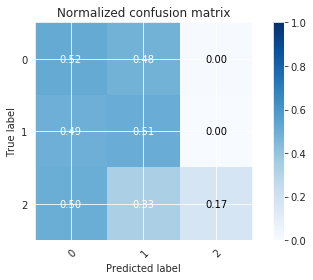

In [0]:
lr = LogisticRegression(solver='lbfgs', max_iter=100000, multi_class='auto')
lr.fit(invoice_train, y_train.values.ravel())
y_pred = lr.predict(invoice_test)

plot_confusion_matrix(y_test, y_pred, normalize=True)
print(classification_report(y_test, y_pred))

In [0]:
from sklearn.model_selection import ParameterGrid

folds = {}
kf = KFold(5, shuffle=True, random_state=0)

for i, (train_index, test_index) in enumerate(kf.split(dtrain)):
    folds[i] = {
        'train_index': train_index,
        'test_index': test_index,
        'X_train': filter_rows_csr(invoice_train, train_index),
        'X_test': filter_rows_csr(invoice_train, test_index),
        'y_train': y_train.iloc[train_index].values,
        'y_test': y_train.iloc[test_index].values,
    }

param_grid = dict(
    solver = ('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'),
    class_weight = (None, 'balanced'),
    penalty = ('none', 'elasticnet'),
    multi_class = ('ovr', 'multinomial', 'auto'),
    C = (0.01, 0.1, 1, 10),
    l1_ratio = (0, 0.1, 0.25, 0.5, 0.9, 1),
)

param_grid = trim_logreg_param_grid(param_grid)

def evaluate_logreg(**params):
    
    scores = []

    for i in range(5):
        estimator = LogisticRegression(max_iter=10000, **params)
        estimator.fit(folds[i]['X_train'], folds[i]['y_train'].ravel())
        y_pred = estimator.predict(folds[i]['X_test'])
        scores.append(f1_score(folds[i]['y_test'], y_pred, average='macro'))
    
    return np.mean(scores)
            
def evaluate_params(param_grid):  
    best_score = 0
    best_params = {}

    for params in param_grid:

        score = evaluate_logreg(**params)

        if score > best_score:
            best_score = score
            best_params = params
            print(f"New best score {score} with")
            print(f"params: {best_params}", end='\n\n')

    return best_params, best_score

In [0]:
best_params, best_score = evaluate_params(param_grid)

New best score 0.3571166263058817 with
params: {'class_weight': None, 'multi_class': 'ovr', 'penalty': 'none', 'solver': 'saga'}



KeyboardInterrupt: ignored

In [0]:
price_encoder = StandardScaler(with_mean=False)
price_scaled_train = price_encoder.fit_transform(price_train)
price_scaled_test = price_encoder.transform(price_test)

price_join_train = np.hstack((invoice0_train, price_scaled_train.toarray()))
price_join_test = np.hstack((invoice0_test, price_scaled_test.toarray()))

reduc = Isomap(n_neighbors=7, n_components=10)

invoice_train = reduc.fit_transform(price_join_train)
invoice_test = reduc.transform(price_join_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:516: RuntimeWarning:

invalid value encountered in multiply



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           0       0.52      0.50      0.51       427
           1       0.52      0.56      0.54       428
           2       0.00      0.00      0.00        12

    accuracy                           0.52       867
   macro avg       0.35      0.35      0.35       867
weighted avg       0.51      0.52      0.52       867



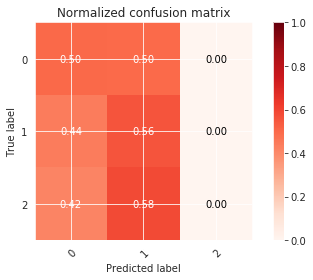

In [0]:
lr = LogisticRegression(solver='lbfgs', max_iter=100000, multi_class='auto')
lr.fit(invoice_train, y_train.values.ravel())
y_pred = lr.predict(invoice_test)

plot_confusion_matrix(y_test, y_pred, normalize=True)
print(classification_report(y_test, y_pred))